# SIGMA \begin{equation*} \frac{\partial V}{\partial t} = \Psi + \Omega \end{equation*}
## **SOSE**

In [243]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(30)
client = cluster.get_client()

In [244]:
client

<Client: 'tls://10.2.61.3:8786' processes=0 threads=0, memory=0 B>

In [3]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
import gsw
#from fastjmd95 import jmd95numba
import fastjmd95 
import json

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
#bringing in uploaded ds

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

def open_ds(filename):
    path = "pangeo-tmp/stb2145/models/SOSE/"
    return xr.open_zarr(gcfs_w_token.get_mapper(path + filename), consolidated=False)

coords = open_ds('coords_wg.zarr')
ds_sig_theta = open_ds('ds_sig_theta_wg.zarr')
ds_sig_salt = open_ds('ds_sig_salt_wg.zarr')
ds_drhodts = open_ds('drhodts_wg.zarr')
ds_tns = open_ds('ds_tns.zarr')
ds_vel = open_ds('ds_vel.zarr')
ds_empmr = open_ds('ds_SIempmr.zarr')

In [6]:
unrolled = xr.merge([ds_empmr, ds_tns, ds_vel])

In [7]:
#WG boundaries (65˚W, 30˚E; 80˚S, 57˚S)
#WG model's boundaries (-77.87497˚S, -57.041634˚S; 295.08334W, 30.083334E)
lower_lat = 0 #-77.87497
upper_lat = 125 #-57.041634
left_lon =  310 #51.75
right_lon = 880 #146.75

#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))
lat_range_u = dict(YG=slice(lower_lat, upper_lat+1))
lon_range_u = dict(XG=slice(left_lon, right_lon+1))

rolled = unrolled.roll(XC=700, XG=700, roll_coords=True).isel(**lat_range, **lon_range, **lat_range_u, **lon_range_u)

In [8]:
ds = xr.merge([ds_sig_theta, ds_sig_salt, ds_drhodts, rolled])
ds

<xarray.Dataset>
Dimensions:                   (XC: 570, YC: 125, Z: 42, time: 438, XG: 571,
                               YG: 126, Zl: 42)
Coordinates:
  * XC                        (XC) float32 295.1 295.2 295.4 ... 29.75 29.92
  * YC                        (YC) float32 -77.87 -77.71 ... -57.37 -57.21
  * Z                         (Z) float32 -5.0 -15.5 ... -5.325e+03 -5.575e+03
  * time                      (time) datetime64[ns] 2005-01-06 ... 2010-12-31
  * XG                        (XG) float32 295.0 295.2 295.3 ... 29.83 30.0
  * YG                        (YG) float32 -77.96 -77.79 ... -57.29 -57.12
  * Zl                        (Zl) float32 0.0 -10.0 ... -5.2e+03 -5.45e+03
Data variables: (12/25)
    conv_horiz_adv_flux_TH    (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 125, 570), meta=np.ndarray>
    conv_horiz_diff_flux_TH   (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 125, 570), meta=np.ndarray>
    conv_vert_adv_flux_TH     (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 125, 570), meta=np.ndarray>
    conv_vert_diff_flux_TH    (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 125, 570), meta=np.ndarray>
    lin_fs_correction_TH      (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 125, 570), meta=np.ndarray>
    surface_flux_conv_TH      (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 125, 570), meta=np.ndarray>
    ...                        ...
    THETA                     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 125, 570), meta=np.ndarray>
    UVEL                      (time, Z, YC, XG) float32 dask.array<chunksize=(1, 42, 125, 571), meta=np.ndarray>
    VVEL                      (time, Z, YG, XC) float32 dask.array<chunksize=(1, 42, 126, 570), meta=np.ndarray>
    WSLTMASS                  (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 42, 125, 570), meta=np.ndarray>
    WTHMASS                   (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 42, 125, 570), meta=np.ndarray>
    WVEL                      (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 42, 125, 570), meta=np.ndarray>

In [9]:
pref = 2000

In [10]:
mask = coords.hFacC[0] > 0

### Checking if `rhs` and `lhs` seem to match

In [11]:
ds_sig_salt.data_vars

Data variables:
    conv_horiz_adv_flux_SLT   (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 125, 570), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 125, 570), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 125, 570), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 125, 570), meta=np.ndarray>
    lin_fs_correction_SLT     (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 125, 570), meta=np.ndarray>
    surface_flux_conv_SLT     (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 125, 570), meta=np.ndarray>
    total_tendency_SLT_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 125, 570), meta=np.ndarray>

In [12]:
rhs_vars_theta = [dvar for dvar in ds_sig_theta.data_vars
                  if dvar != 'total_tendency_TH_truth']
rhs_vars_salt = [dvar for dvar in ds_sig_salt.data_vars
                  if dvar != 'total_tendency_SLT_truth']

In [13]:
theta_sum = sum([ds_sig_theta[dvar] for dvar in rhs_vars_theta])
salt_sum = sum([ds_sig_salt[dvar] for dvar in rhs_vars_salt])
total_tendency_check = theta_sum + salt_sum
total_tendency_check

<xarray.DataArray (time: 438, Z: 42, YC: 125, XC: 570)>
dask.array<add, shape=(438, 42, 125, 570), dtype=float64, chunksize=(1, 42, 125, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -57.54 -57.37 -57.21
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

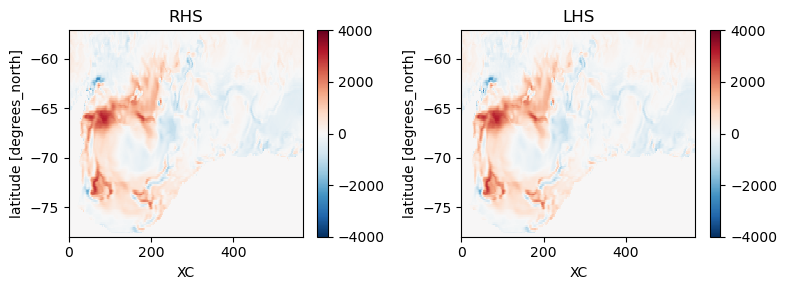

In [14]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8, 3))
total_tendency_check[1, 0].drop('XC').plot(ax=ax0, robust=True, vmax=4e3)
ax0.set_title('RHS')

(ds.total_tendency_TH_truth + ds.total_tendency_SLT_truth)[1, 0].drop('XC').plot(ax=ax1, robust=True, vmax=4e3)
ax1.set_title('LHS')
plt.tight_layout();

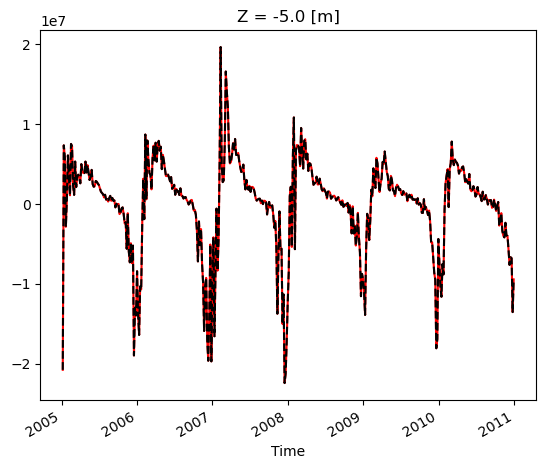

In [15]:
total_tendency_check.isel(Z=0).sum(['XC', 'YC']).plot(color='r')
(ds.total_tendency_TH_truth + ds.total_tendency_SLT_truth).isel(Z=0).sum(['XC', 'YC']).plot(color='k', linestyle='--')

# <font color='Green'>\begin{equation*} \sigma_2\ term \end{equation*} </font>

In [16]:
sigma2 = fastjmd95.rho(ds.SALT, ds.THETA, pref)
sigma2

<xarray.DataArray (time: 438, Z: 42, YC: 125, XC: 570)>
dask.array<transpose, shape=(438, 42, 125, 570), dtype=float64, chunksize=(1, 42, 125, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -57.54 -57.37 -57.21
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [17]:
sigma2.nbytes/1e9

10.48572

### Volume-weighted $\frac{\partial{\sigma_2}}{\partial t} =$ _tottend_truth_

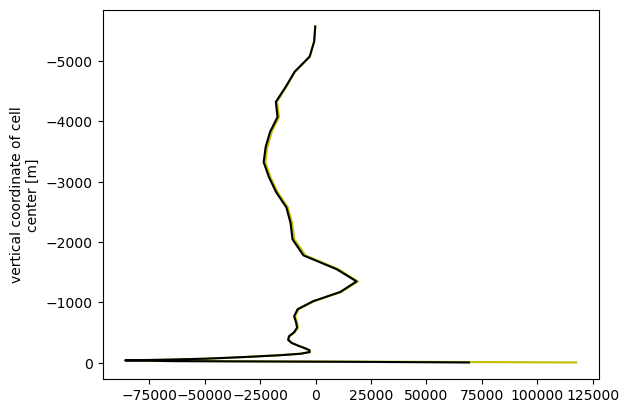

In [18]:
delta_sigma = sigma2.isel(time=-1) - sigma2.isel(time=0)
total_time = (sigma2.time[-1] - sigma2.time[0]).astype('f8')*1e-9

vol = (coords.drF * coords.rA * coords.hFacC)
((delta_sigma * vol).sum(dim=['YC', 'XC'])/ total_time).plot(y='Z', yincrease=False, color='y')
(ds.total_tendency_SLT_truth + ds.total_tendency_TH_truth).sum(dim=['YC', 'XC']).mean(dim='time').plot(y='Z', yincrease=False, color='k')

In [19]:
totend_truth = (delta_sigma * vol) / total_time

In [20]:
dt = ds.time.diff(dim='time').astype(np.float64) / 1e9

In [21]:
dt.time

<xarray.DataArray 'time' (time: 437)>
array(['2005-01-11T00:00:00.000000000', '2005-01-16T00:00:00.000000000',
       '2005-01-21T00:00:00.000000000', ..., '2010-12-21T00:00:00.000000000',
       '2010-12-26T00:00:00.000000000', '2010-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2005-01-11 2005-01-16 ... 2010-12-31
Attributes:
    axis:           T
    long_name:      Time
    standard_name:  time

In [22]:
sigma2.diff(dim='time').coords

Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -57.54 -57.37 -57.21
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
  * time     (time) datetime64[ns] 2005-01-11 2005-01-16 ... 2010-12-31

In [23]:
dsig_dt = (sigma2.diff(dim='time')*vol)/dt

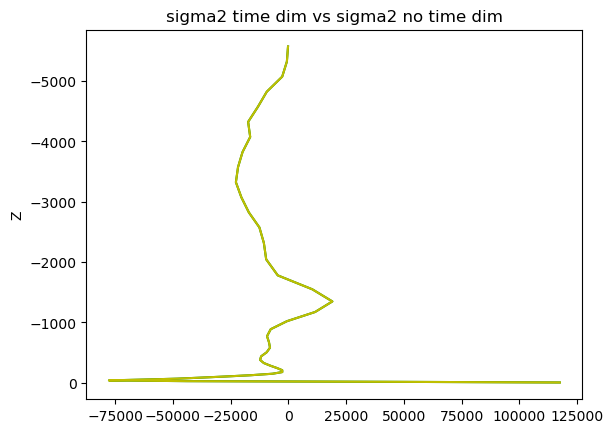

In [24]:
dsig_dt.sum(dim=['YC', 'XC']).mean(dim='time').plot(y='Z', yincrease=False, color='green')
totend_truth.sum(dim=['YC', 'XC']).plot(y='Z', yincrease=False, color='y')
plt.title('sigma2 time dim vs sigma2 no time dim');

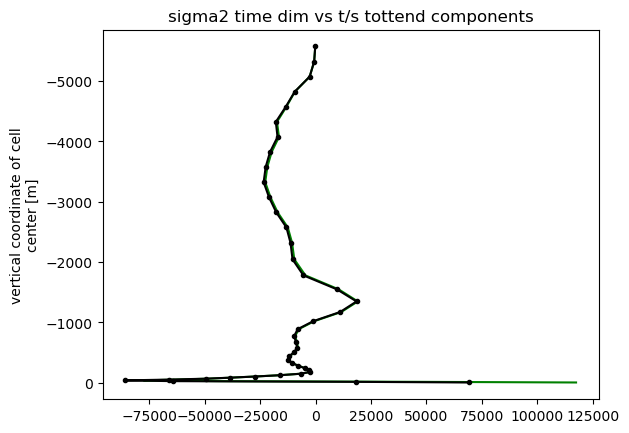

In [25]:
((sigma2.diff(dim='time')*vol)/dt).mean(dim='time').sum(dim=['YC', 'XC']).plot(y='Z', yincrease=False, color='green')
(ds.total_tendency_SLT_truth + ds.total_tendency_TH_truth).sum(dim=['YC', 'XC']).mean(dim='time').plot(y='Z', yincrease=False, color='k', marker='.')
plt.title('sigma2 time dim vs t/s tottend components');

In [26]:
totend_truth = (sigma2.diff(dim='time')*vol) / dt

# <font color='Green'>\begin{equation*} \frac{\partial V}{\partial t} == \Omega_{tottend-\sigma-truth} + R1 \end{equation*} </font>

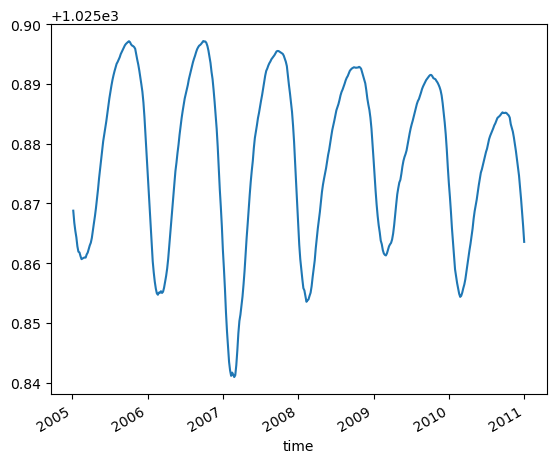

In [27]:
#looks strange but it's similar to ECCO considering the shorter time period
#density avged over volume gets denser in middle of the year (AA winter) and lighter around spring/summer
sigma2.mean(dim=['XC', 'YC', 'Z']).plot()

In [28]:
delta_sigma = 0.01
sigma_bins = np.arange(1027.5, 1037.5, delta_sigma)

In [29]:
sigma_bins.size

1000

In [30]:
ds = ds.chunk({'XC':-1, 'YC':-1, 'Z':-1, 'XG':-1, 'YG':-1, 'Zl':-1, 'time':1})
coords = coords.chunk({'XC':-1, 'YC':-1, 'Z':-1, 'XG':-1, 'YG':-1, 'Zl':-1, 'time':1})

In [31]:
sigma2

<xarray.DataArray (time: 438, Z: 42, YC: 125, XC: 570)>
dask.array<transpose, shape=(438, 42, 125, 570), dtype=float64, chunksize=(1, 42, 125, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -57.54 -57.37 -57.21
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [32]:
#load in autoreload so you don't have to restart kernel everytime you want to run bb function
%load_ext autoreload

#Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2

In [33]:
import bb

In [44]:
#sigma2 and vol boxes

box1_sigma2 = bb.slice_box(sigma2, 57, 570, 88, 125, cell='c')
box2_sigma2 = bb.slice_box(sigma2, 36, 570, 77, 88, cell='c')
box3_sigma2 = bb.slice_box(sigma2, 5, 570, 73, 77, cell='c')
box4_sigma2 = bb.slice_box(sigma2, 0, 570, 0, 73, cell='c')

box1_vol = bb.slice_box(vol, 57, 570, 88, 125, cell='c')
box2_vol = bb.slice_box(vol, 36, 570, 77, 88, cell='c')
box3_vol = bb.slice_box(vol, 5, 570, 73, 77, cell='c')
box4_vol = bb.slice_box(vol, 0, 570, 0, 73, cell='c')

In [56]:
#sigma_dist boxes

sigma_dist1 = histogram(box1_sigma2.rename('sigma2'), bins=[sigma_bins],
                       weights=box1_vol, dim=['XC', 'YC', 'Z']).load()

sigma_dist2 = histogram(box2_sigma2.rename('sigma2'), bins=[sigma_bins],
                       weights=box2_vol, dim=['XC', 'YC', 'Z']).load()

sigma_dist3 = histogram(box3_sigma2.rename('sigma2'), bins=[sigma_bins],
                       weights=box3_vol, dim=['XC', 'YC', 'Z']).load()

sigma_dist4 = histogram(box4_sigma2.rename('sigma2'), bins=[sigma_bins],
                       weights=box4_vol, dim=['XC', 'YC', 'Z']).load()

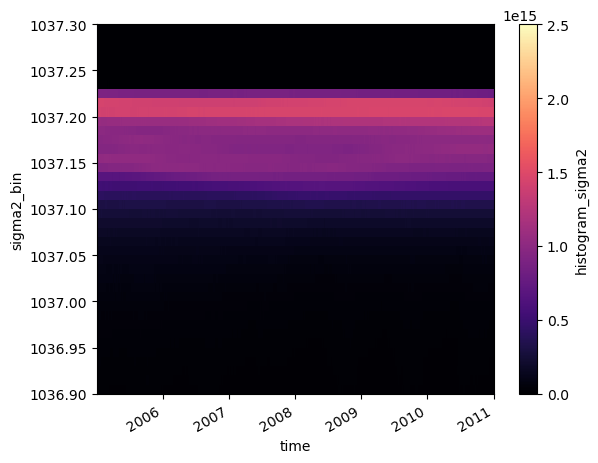

In [60]:
sigma_dist1.plot(x='time', vmax=2.5e15, cmap='magma')
plt.ylim(1036.9, 1037.3);

In [61]:
sigma_dist = sigma_dist1 + sigma_dist2 + sigma_dist3 + sigma_dist4

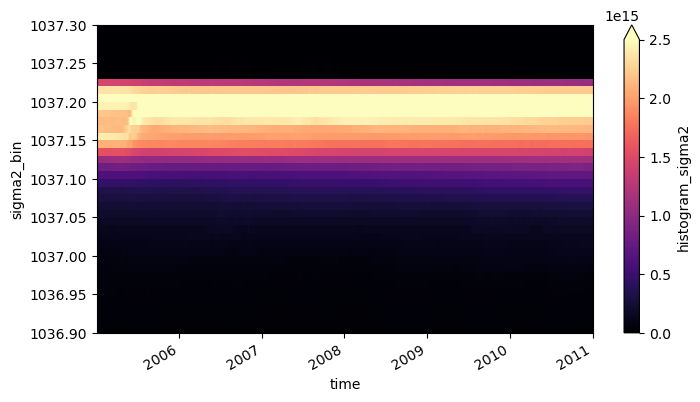

In [65]:
sigma_dist.plot(x='time', figsize=(8, 4), vmax=2.5e15, cmap='magma')
plt.ylim(1036.9, 1037.3);

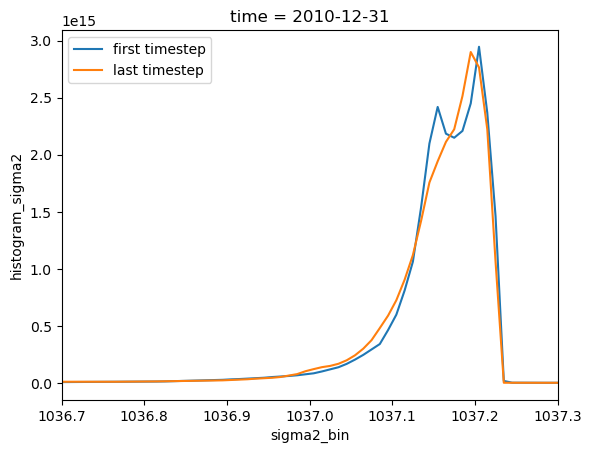

In [66]:
#waters with density up to 1037.13 got denser?
sigma_dist[0].plot(label='first timestep')
sigma_dist[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1036.7, 1037.3);

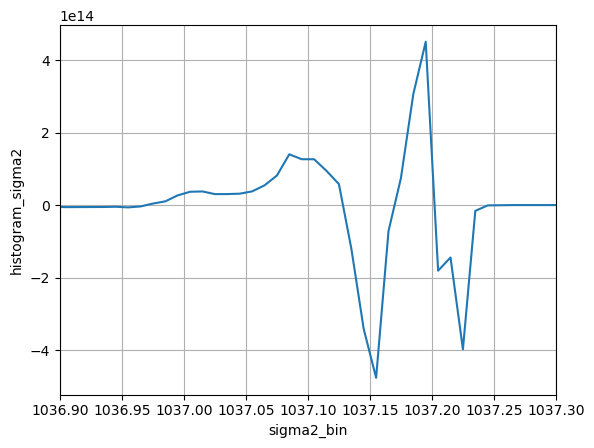

In [68]:
(sigma_dist[-1] - sigma_dist[0]).plot()
plt.xlim(1036.9, 1037.3)
plt.grid();

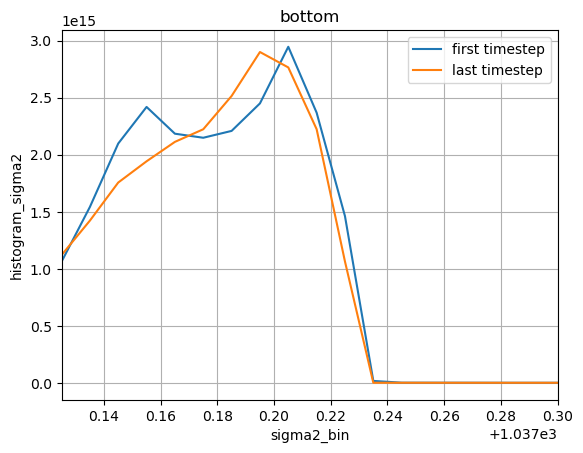

In [69]:
sigma_dist[0].plot(label='first timestep')
sigma_dist[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1037.125, 1037.3)
plt.grid()
plt.title('bottom');

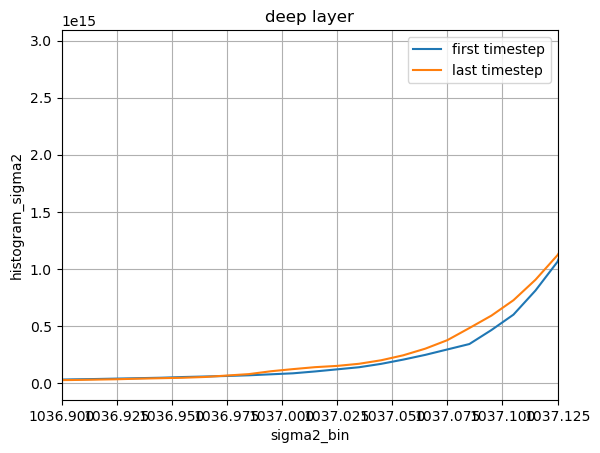

In [70]:
sigma_dist[0].plot(label='first timestep')
sigma_dist[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1036.9, 1037.125)
plt.grid()
plt.title('deep layer');

(1037.5, 1036.4)

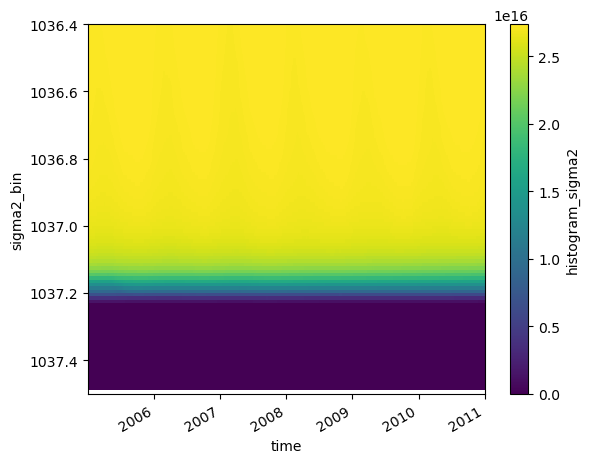

In [71]:
# cumulative volume
V = sigma_dist.isel(sigma2_bin=slice(None, None, -1)).cumsum(dim='sigma2_bin')
V.transpose().plot()
plt.ylim(1037.5, 1036.4)

In [72]:
V

<xarray.DataArray 'histogram_sigma2' (time: 438, sigma2_bin: 999)>
array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 2.7376169e+16,
        2.7376169e+16, 2.7376169e+16],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 2.7376169e+16,
        2.7376169e+16, 2.7376169e+16],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 2.7376162e+16,
        2.7376162e+16, 2.7376162e+16],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 2.7376182e+16,
        2.7376182e+16, 2.7376182e+16],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 2.7376186e+16,
        2.7376186e+16, 2.7376186e+16],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 2.7376184e+16,
        2.7376184e+16, 2.7376184e+16]], dtype=float32)
Coordinates:
  * time        (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.028e+03 1.028e+03

(1036.5, 1037.5)

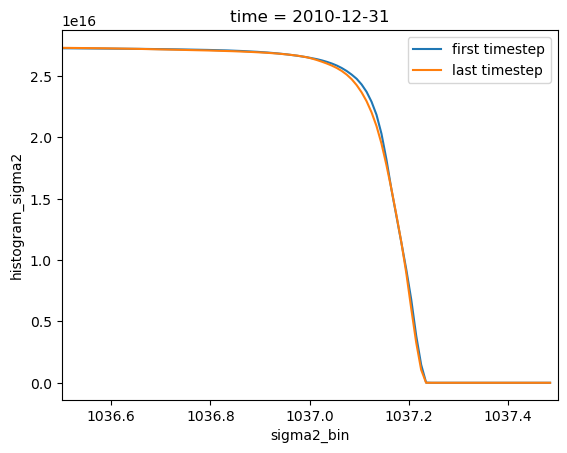

In [75]:
#waters with densities up to 1037.0 became lost volume and moved into denser sigma bins?
V[0].plot(label='first timestep')
V[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1036.5, 1037.5)

In [76]:
delta_V = V.diff(dim='time')

In [77]:
delta_V

<xarray.DataArray 'histogram_sigma2' (time: 437, sigma2_bin: 999)>
array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -6.4424509e+09, -6.4424509e+09, -6.4424509e+09],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         1.5032386e+10,  1.5032386e+10,  1.5032386e+10],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         6.4424509e+09,  6.4424509e+09,  6.4424509e+09],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         4.2949673e+09,  4.2949673e+09,  4.2949673e+09],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -2.1474836e+09, -2.1474836e+09, -2.1474836e+09]], dtype=float32)
Coordinates:
  * time        (time) datetime64[ns] 2005-01-11 2005-01-16 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.028e+03 1.028e+03

## $\frac{\partial \mathcal{V}}{\partial t}$

In [78]:
delta_V.time

<xarray.DataArray 'time' (time: 437)>
array(['2005-01-11T00:00:00.000000000', '2005-01-16T00:00:00.000000000',
       '2005-01-21T00:00:00.000000000', ..., '2010-12-21T00:00:00.000000000',
       '2010-12-26T00:00:00.000000000', '2010-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2005-01-11 2005-01-16 ... 2010-12-31

In [80]:
dt.time

<xarray.DataArray 'time' (time: 437)>
array(['2005-01-11T00:00:00.000000000', '2005-01-16T00:00:00.000000000',
       '2005-01-21T00:00:00.000000000', ..., '2010-12-21T00:00:00.000000000',
       '2010-12-26T00:00:00.000000000', '2010-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2005-01-11 2005-01-16 ... 2010-12-31
Attributes:
    axis:           T
    long_name:      Time
    standard_name:  time

In [81]:
dVdt = delta_V / dt

In [82]:
dVdt

<xarray.DataArray (time: 437, sigma2_bin: 999)>
array([[     0.        ,      0.        ,      0.        , ...,
             0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        , ...,
        -14913.08088889, -14913.08088889, -14913.08088889],
       [     0.        ,      0.        ,      0.        , ...,
         34797.18874074,  34797.18874074,  34797.18874074],
       ...,
       [     0.        ,      0.        ,      0.        , ...,
         14913.08088889,  14913.08088889,  14913.08088889],
       [     0.        ,      0.        ,      0.        , ...,
          9942.05392593,   9942.05392593,   9942.05392593],
       [     0.        ,      0.        ,      0.        , ...,
         -4971.02696296,  -4971.02696296,  -4971.02696296]])
Coordinates:
  * time        (time) datetime64[ns] 2005-01-11 2005-01-16 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.028e+03 1.028e+03

(1037.3, 1036.5)

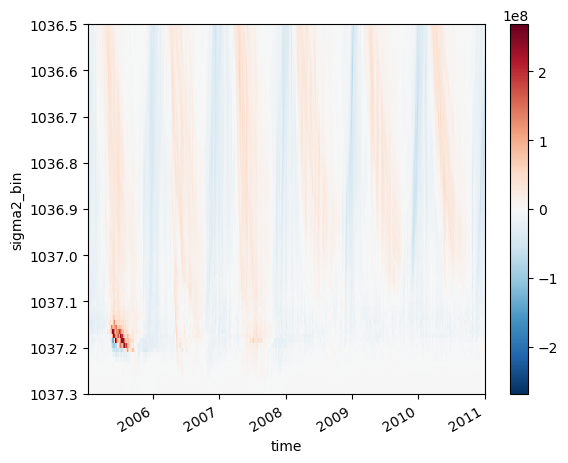

In [87]:
dVdt.plot(x='time', yincrease=False)
plt.ylim(1037.3, 1036.5)

## $\Omega_{total}$

In [90]:
#total tendency th - weights for omega total th

tot_th1 = bb.slice_box(ds.total_tendency_TH_truth, 57, 570, 88, 125, cell='c')
tot_th2 = bb.slice_box(ds.total_tendency_TH_truth, 36, 570, 77, 88, cell='c')
tot_th3 = bb.slice_box(ds.total_tendency_TH_truth, 5, 570, 73, 77, cell='c')
tot_th4 = bb.slice_box(ds.total_tendency_TH_truth, 0, 570, 0, 73, cell='c')

#total tendency slt - weights for omega total slt

tot_slt1 = bb.slice_box(ds.total_tendency_SLT_truth, 57, 570, 88, 125, cell='c')
tot_slt2 = bb.slice_box(ds.total_tendency_SLT_truth, 36, 570, 77, 88, cell='c')
tot_slt3 = bb.slice_box(ds.total_tendency_SLT_truth, 5, 570, 73, 77, cell='c')
tot_slt4 = bb.slice_box(ds.total_tendency_SLT_truth, 0, 570, 0, 73, cell='c')

In [136]:
#omega total boxes

#omega_th
omega_tot_th1 = (histogram(box1_sigma2.rename('sigma2'), bins=[sigma_bins],
                       weights=tot_th1.fillna(0.), dim=['XC', 'YC', 'Z']) / delta_sigma).load()
omega_tot_th2 = (histogram(box2_sigma2.rename('sigma2'), bins=[sigma_bins],
                       weights=tot_th2.fillna(0.), dim=['XC', 'YC', 'Z']) / delta_sigma).load()
omega_tot_th3 = (histogram(box3_sigma2.rename('sigma2'), bins=[sigma_bins],
                       weights=tot_th3.fillna(0.), dim=['XC', 'YC', 'Z']) / delta_sigma).load()
omega_tot_th4 = (histogram(box4_sigma2.rename('sigma2'), bins=[sigma_bins],
                       weights=tot_th4.fillna(0.), dim=['XC', 'YC', 'Z']) / delta_sigma).load()

#omega_slt
omega_tot_slt1 = (histogram(box1_sigma2.rename('sigma2'), bins=[sigma_bins],
                       weights=tot_slt1.fillna(0.), dim=['XC', 'YC', 'Z']) / delta_sigma).load()
omega_tot_slt2 = (histogram(box2_sigma2.rename('sigma2'), bins=[sigma_bins],
                       weights=tot_slt2.fillna(0.), dim=['XC', 'YC', 'Z']) / delta_sigma).load()
omega_tot_slt3 = (histogram(box3_sigma2.rename('sigma2'), bins=[sigma_bins],
                       weights=tot_slt3.fillna(0.), dim=['XC', 'YC', 'Z']) / delta_sigma).load()
omega_tot_slt4 = (histogram(box4_sigma2.rename('sigma2'), bins=[sigma_bins],
                       weights=tot_slt4.fillna(0.), dim=['XC', 'YC', 'Z']) / delta_sigma).load()

omega_total_th = (omega_tot_th1 + omega_tot_th2 + omega_tot_th3 + omega_tot_th4)
omega_total_slt = (omega_tot_slt1 + omega_tot_slt2 + omega_tot_slt3 + omega_tot_slt4)
omega_total = (omega_tot_th1 + omega_tot_th2 + omega_tot_th3 + omega_tot_th4 + 
               omega_tot_slt1 + omega_tot_slt2 + omega_tot_slt3 + omega_tot_slt4)

In [93]:
totend_truth.coords

Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -57.54 -57.37 -57.21
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
  * time     (time) datetime64[ns] 2005-01-11 2005-01-16 ... 2010-12-31

In [97]:
box1_sigma2[1:].coords

Coordinates:
  * XC       (XC) float32 304.6 304.8 304.9 305.1 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -63.21 -63.04 -62.87 -62.71 ... -57.54 -57.37 -57.21
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
  * time     (time) datetime64[ns] 2005-01-11 2005-01-16 ... 2010-12-31

In [137]:
#second way to compute omega total boxes using totend_truth=sigma*vol/dt

#total tendency - weights for omega total
tottend1 = bb.slice_box(totend_truth, 57, 570, 88, 125, cell='c')
tottend2 = bb.slice_box(totend_truth, 36, 570, 77, 88, cell='c')
tottend3 = bb.slice_box(totend_truth, 5, 570, 73, 77, cell='c')
tottend4 = bb.slice_box(totend_truth, 0, 570, 0, 73, cell='c')

#omega_total
omega_tot11 = (histogram(box1_sigma2[1:].rename('sigma2'), bins=[sigma_bins],
                       weights=tottend1.fillna(0.), dim=['XC', 'YC', 'Z']) / delta_sigma).load()
omega_tot21 = (histogram(box2_sigma2[1:].rename('sigma2'), bins=[sigma_bins],
                       weights=tottend2.fillna(0.), dim=['XC', 'YC', 'Z']) / delta_sigma).load()
omega_tot31 = (histogram(box3_sigma2[1:].rename('sigma2'), bins=[sigma_bins],
                       weights=tottend3.fillna(0.), dim=['XC', 'YC', 'Z']) / delta_sigma).load()
omega_tot41 = (histogram(box4_sigma2[1:].rename('sigma2'), bins=[sigma_bins],
                       weights=tottend4.fillna(0.), dim=['XC', 'YC', 'Z']) / delta_sigma).load()

omega_tot_2nd = (omega_tot11 + omega_tot21 + omega_tot31 + omega_tot41)

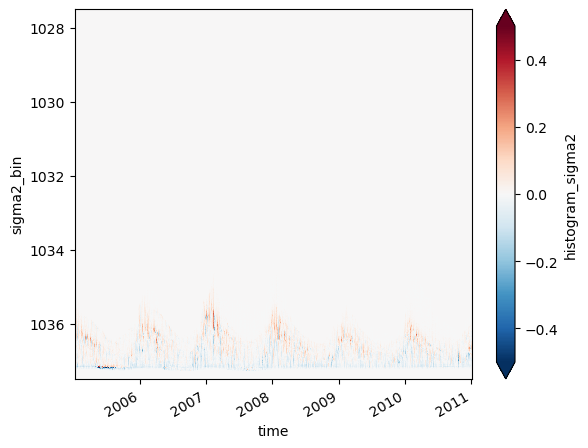

In [139]:
#test to see if there is a diff between weights
#if no difference, then use totend_truth as weights for simpler computation

((omega_total - omega_tot_2nd)/1e8).T.plot(yincrease=False, vmin=-0.5, vmax=0.5, cmap='RdBu_r');

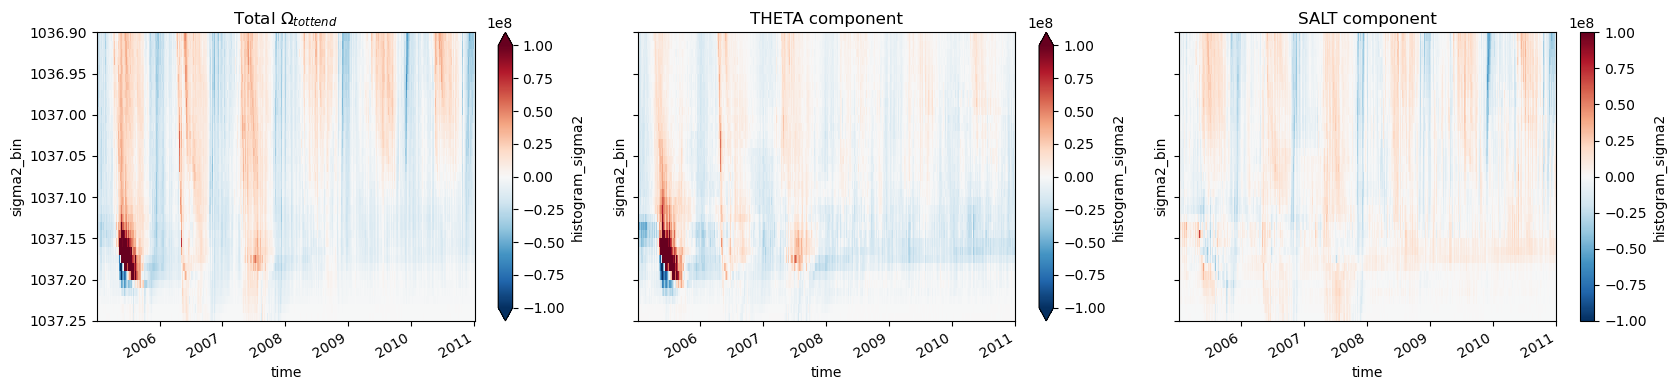

In [140]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, sharey=True, figsize=(17,4))

omega_total.plot(x='time', vmax=1e8, ax=ax0, yincrease=False)
ax0.set_title(r'Total $\Omega_{tottend}$')

omega_total_th.plot(x='time', vmax=1e8, ax=ax1, yincrease=False)
ax1.set_title('THETA component')

omega_total_slt.plot(x='time', vmax=1e8, ax=ax2, yincrease=False)
ax2.set_ylim(ymax=1036.9, ymin=1037.25)
ax2.set_title('SALT component')

plt.tight_layout();

## <font color='Green'>\begin{equation*} R1 = \frac{\partial \mathcal{V}}{\partial t} - \Omega_{total} \end{equation*} (Discretization of salt layers) </font>

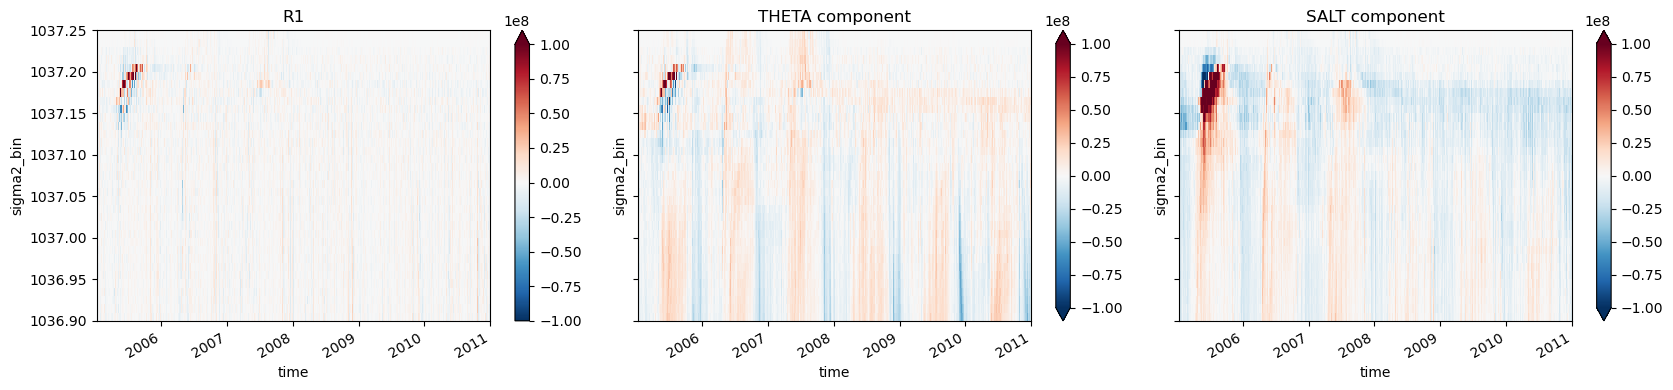

In [149]:
R1 = dVdt - omega_total
R1_th = dVdt - omega_total_th
R1_slt = dVdt - omega_total_slt

fig, (ax0,ax1,ax2) = plt.subplots(1,3, sharey=True, figsize=(17,4))

R1.plot(x='time', vmax=1e8, ax=ax0)
ax0.set_title('R1')

R1_th.plot(x='time', vmax=1e8, ax=ax1)
ax1.set_title('THETA component')

R1_slt.plot(x='time', vmax=1e8, ax=ax2, yincrease=False)
ax2.set_ylim(ymax=1037.25, ymin=1036.9)
ax2.set_title('SALT component')

plt.tight_layout();

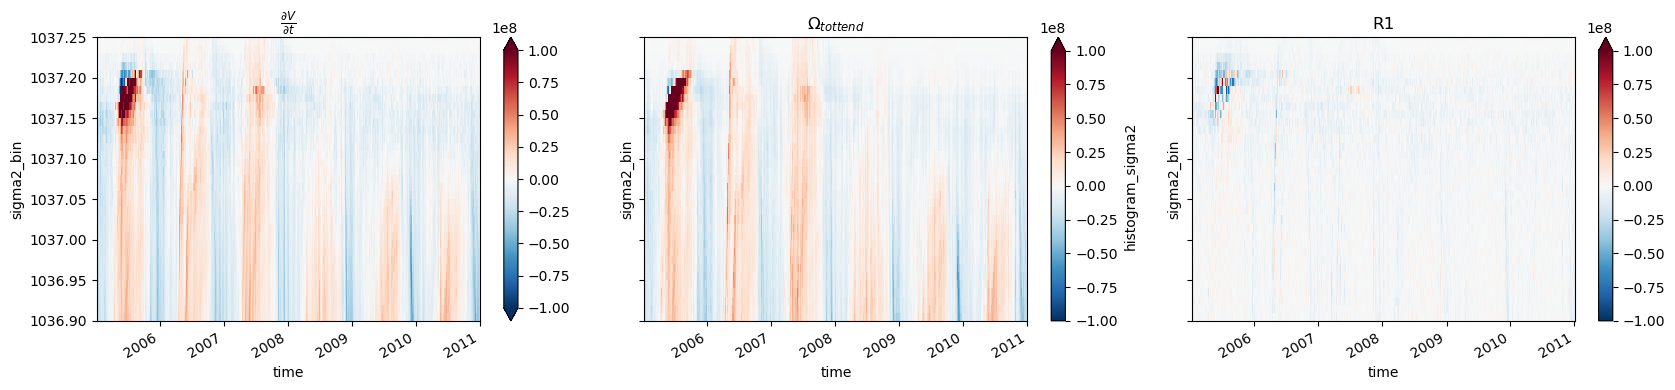

In [148]:
R1_2nd = dVdt - omega_tot_2nd

fig, (ax0,ax1,ax2) = plt.subplots(1,3, sharey=True, figsize=(17,4))

dVdt.plot(x='time', vmax=1e8, ax=ax0)
#ax0.set_ylim(ymax=1037.25, ymin=1035.5)
ax0.set_title(r'$\frac{\partial{V}}{\partial{t}}$')

omega_tot_2nd.plot(x='time', vmax=1e8, ax=ax1)
#ax1.set_ylim(ymax=1037.25, ymin=1035.5)
ax1.set_title(r'$\Omega_{tottend}$')

R1_2nd.plot(x='time', vmax=1e8, ax=ax2)
ax2.set_ylim(ymax=1037.25, ymin=1036.9)
ax2.set_title('R1')

plt.tight_layout();

In [151]:
plot_terms = np.array([[dVdt, omega_total, R1], [dVdt, omega_total_th, R1_th], [dVdt, omega_total_slt, R1_slt]])
plot_term_titles = np.array([[r'$\frac{\partial \mathcal{V}}{\partial t}$', 
                              '$\Omega$ (total_tendency)', 
                              r'Residual of $\frac{\partial \mathcal{V}}{\partial t}$ and $\Omega$'],
                              [r'$\frac{\partial \mathcal{V}}{\partial t}$',
                              r'$\Omega_{tottend}$ Theta Component',
                              r'R1 Theta Component'],
                              [r'$\frac{\partial \mathcal{V}}{\partial t}$',
                              r'$\Omega_{tottend}$ Salt Component',
                              r'R1 Salt Component']])

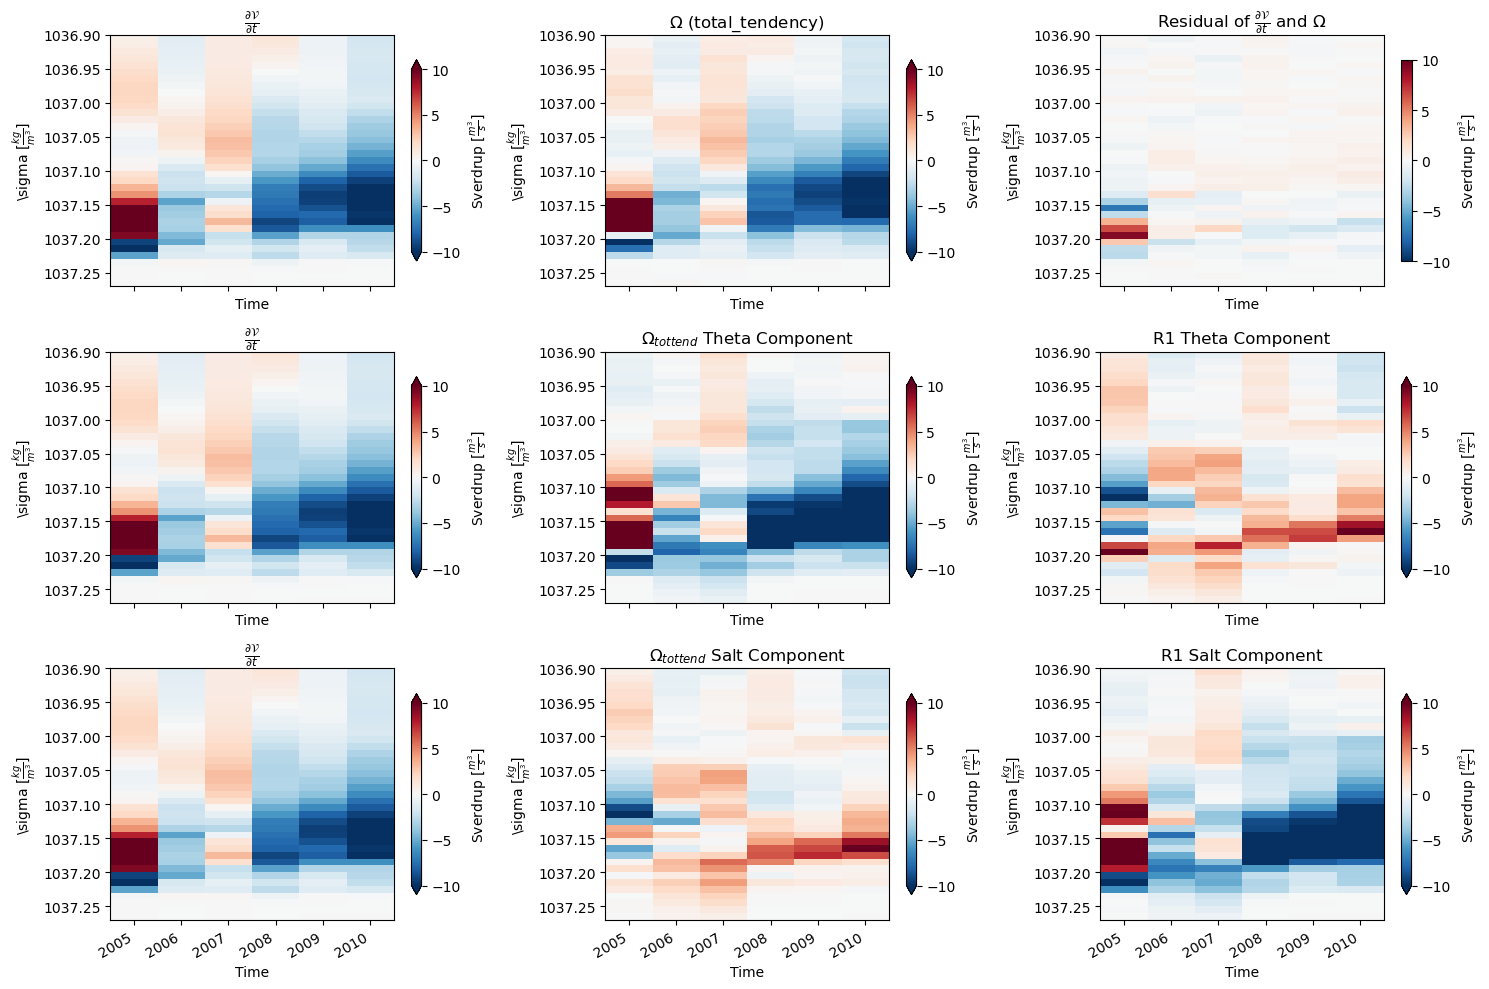

In [152]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)

for i in range(0,3):
    for j in range(0,3): 
        term = plot_terms[i,j]
        title = plot_term_titles[i,j]
        (term/1e6).resample(time='AS').mean(dim='time').plot(x='time', vmax=10, ax=axes[i,j],
                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
        axes[i,j].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
        axes[i,j].set_xlabel('Time')
        axes[i,j].set_title(title)
        axes[i,j].set_ylim(1037.27, 1036.9)
plt.tight_layout();

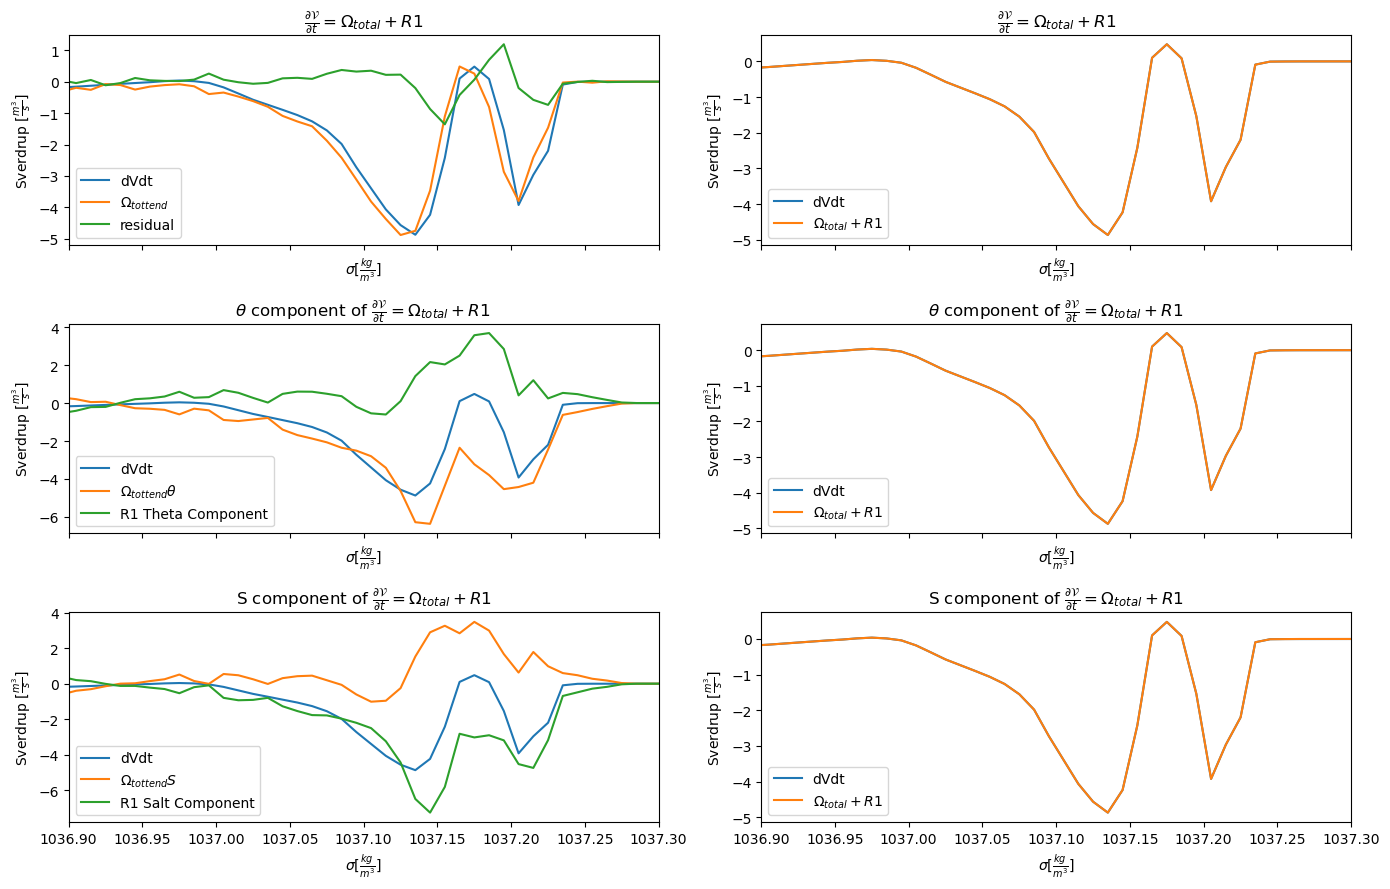

In [153]:
fig, axes = plt.subplots(3, 2, figsize=(14, 9), sharex=True)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[0,0])
(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=axes[0,0])
(R1/1e6).mean(dim='time').plot(label='residual', ax=axes[0,0])
axes[0,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[0,0].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[0,0].legend()
axes[0,0].set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
axes[0,0].set_xlim(1036.9, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[0,1])
((omega_total + R1)/1e6).mean(dim='time').plot(label=r'$\Omega_{total} + R1$', ax=axes[0,1])
axes[0,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[0,1].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[0,1].legend()
axes[0,1].set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
#axes[0,1].set_xlim(1035.5, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[1,0])
(omega_total_th/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend} \theta$', ax=axes[1,0])
(R1_th/1e6).mean(dim='time').plot(label='R1 Theta Component', ax=axes[1,0])
axes[1,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[1,0].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[1,0].legend()
axes[1,0].set_title(r'$\theta$ component of $\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$ ')
#axes[1,0].set_xlim(1035.5, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[1,1])
((omega_total_th + R1_th)/1e6).mean(dim='time').plot(label=r'$\Omega_{total} + R1$', ax=axes[1,1])
axes[1,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[1,1].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[1,1].legend()
axes[1,1].set_title(r'$\theta$ component of $\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
#axes[1,1].set_xlim(1035.5, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[2,0])
(omega_total_slt/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend} S$', ax=axes[2,0])
(R1_slt/1e6).mean(dim='time').plot(label='R1 Salt Component', ax=axes[2,0])
axes[2,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[2,0].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[2,0].legend()
axes[2,0].set_title(r'S component of $\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
#axes[2,0].set_xlim(1035.5, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[2,1])
((omega_total_slt + R1_slt)/1e6).mean(dim='time').plot(label=r'$\Omega_{total} + R1$', ax=axes[2,1])
axes[2,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[2,1].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[2,1].legend()
axes[2,1].set_title(r'S component of $\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
#axes[2,1].set_xlim(1035.5, 1037.3)

plt.tight_layout();

## <span style='color:Green'> \begin{equation*} \Omega_{transformation-rate} \end{equation*}

In [165]:
def histogram_func(weight):
    """Generalized xhistogram's histogram function 
    for adv and diff flux terms"""
    
    #weights section
    box1_weight = bb.slice_box(weight, 57, 570, 88, 125, cell='c')
    box2_weight = bb.slice_box(weight, 36, 570, 77, 88, cell='c')
    box3_weight = bb.slice_box(weight, 5, 570, 73, 77, cell='c')
    box4_weight = bb.slice_box(weight, 0, 570, 0, 73, cell='c')

    #histogram section
    hist1 = histogram(box1_sigma2.rename('sigma2'), bins=[sigma_bins],
                     weights=box1_weight.fillna(0.), dim=['XC', 'YC', 'Z']) / delta_sigma
    hist2 = histogram(box2_sigma2.rename('sigma2'), bins=[sigma_bins],
                     weights=box2_weight.fillna(0.), dim=['XC', 'YC', 'Z']) / delta_sigma
    hist3 = histogram(box3_sigma2.rename('sigma2'), bins=[sigma_bins],
                     weights=box3_weight.fillna(0.), dim=['XC', 'YC', 'Z']) / delta_sigma
    hist4 = histogram(box4_sigma2.rename('sigma2'), bins=[sigma_bins],
                     weights=box4_weight.fillna(0.), dim=['XC', 'YC', 'Z']) / delta_sigma
    hist = hist1 + hist2 + hist3 +hist4
    
    return hist 

In [166]:
all_tendencies_th = list(ds_sig_theta)
all_tendencies_slt = list(ds_sig_salt)

In [167]:
all_dsets_th = xr.merge([histogram_func(ds_sig_theta[var]).rename('OMEGA_' + var)
                      for var in all_tendencies_th])
all_dsets_slt = xr.merge([histogram_func(ds_sig_salt[var]).rename('OMEGA_' + var)
                      for var in all_tendencies_slt])

In [168]:
all_dsets = xr.merge([all_dsets_th, all_dsets_slt])

In [170]:
all_dsets

<xarray.Dataset>
Dimensions:                         (time: 438, sigma2_bin: 999)
Coordinates:
  * time                            (time) datetime64[ns] 2005-01-06 ... 2010...
  * sigma2_bin                      (sigma2_bin) float64 1.028e+03 ... 1.037e+03
Data variables: (12/15)
    OMEGA_conv_horiz_adv_flux_TH    (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>
    OMEGA_conv_horiz_diff_flux_TH   (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>
    OMEGA_conv_vert_adv_flux_TH     (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>
    OMEGA_conv_vert_diff_flux_TH    (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>
    OMEGA_lin_fs_correction_TH      (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>
    OMEGA_surface_flux_conv_TH      (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>
    ...                              ...
    OMEGA_conv_horiz_diff_flux_SLT  (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>
    OMEGA_conv_vert_adv_flux_SLT    (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>
    OMEGA_conv_vert_diff_flux_SLT   (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>
    OMEGA_lin_fs_correction_SLT     (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>
    OMEGA_surface_flux_conv_SLT     (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>
    OMEGA_total_tendency_SLT_truth  (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>

In [164]:
client.restart()

<Client: 'tls://10.2.30.2:8786' processes=27 threads=54, memory=810.00 GiB>

In [172]:
omega_trans_rate_th = (all_dsets_th.OMEGA_conv_horiz_diff_flux_TH + 
                        all_dsets_th.OMEGA_conv_vert_diff_flux_TH +
                        all_dsets_th.OMEGA_lin_fs_correction_TH +
                        all_dsets_th.OMEGA_sw_flux_conv_TH + 
                        all_dsets_th.OMEGA_surface_flux_conv_TH)
omega_trans_rate_th.load()

<xarray.DataArray (time: 438, sigma2_bin: 999)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time        (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

In [173]:
client.restart()

<Client: 'tls://10.2.30.2:8786' processes=0 threads=0, memory=0 B>

In [175]:
omega_trans_rate_slt = (all_dsets_slt.OMEGA_conv_horiz_diff_flux_SLT + 
                          all_dsets_slt.OMEGA_conv_vert_diff_flux_SLT +
                          all_dsets_slt.OMEGA_lin_fs_correction_SLT +
                          all_dsets_slt.OMEGA_surface_flux_conv_SLT)
omega_trans_rate_slt.load()

omega_trans_rate = omega_trans_rate_th + omega_trans_rate_slt
omega_trans_rate.load()

<xarray.DataArray (time: 438, sigma2_bin: 999)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time        (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

In [176]:
test_omega = omega_trans_rate.isel(sigma2_bin=-1) - omega_trans_rate.sel(sigma2_bin=1037.125, method='nearest')
test_omega_slt = omega_trans_rate_slt.isel(sigma2_bin=-1) - omega_trans_rate_slt.sel(sigma2_bin=1037.125, method='nearest')
test_omega_th = omega_trans_rate_th.isel(sigma2_bin=-1) - omega_trans_rate_th.sel(sigma2_bin=1037.125, method='nearest')

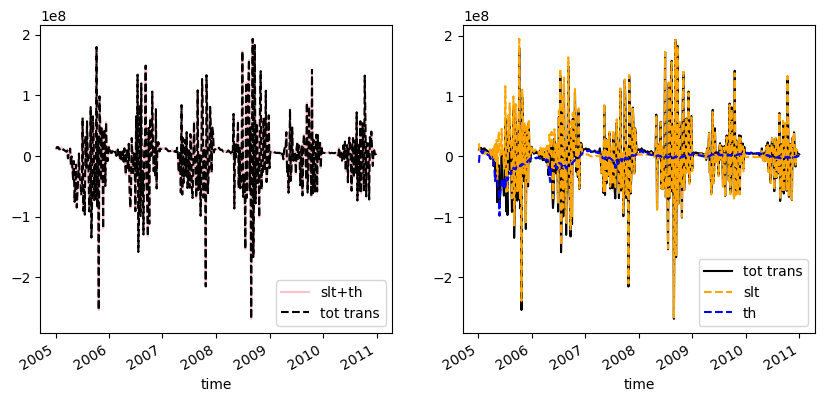

In [177]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4))

(test_omega_slt+test_omega_th).plot(label='slt+th', ax=ax0, color='pink')
test_omega.plot(label='tot trans', ax=ax0, linestyle='--', color='k')
ax0.legend()

test_omega.plot(label='tot trans', color='k', ax=ax1)
test_omega_slt.plot(label='slt', color='orange', linestyle='--', ax=ax1)
test_omega_th.plot(label='th', color='blue', linestyle='--', ax=ax1)
ax1.legend();

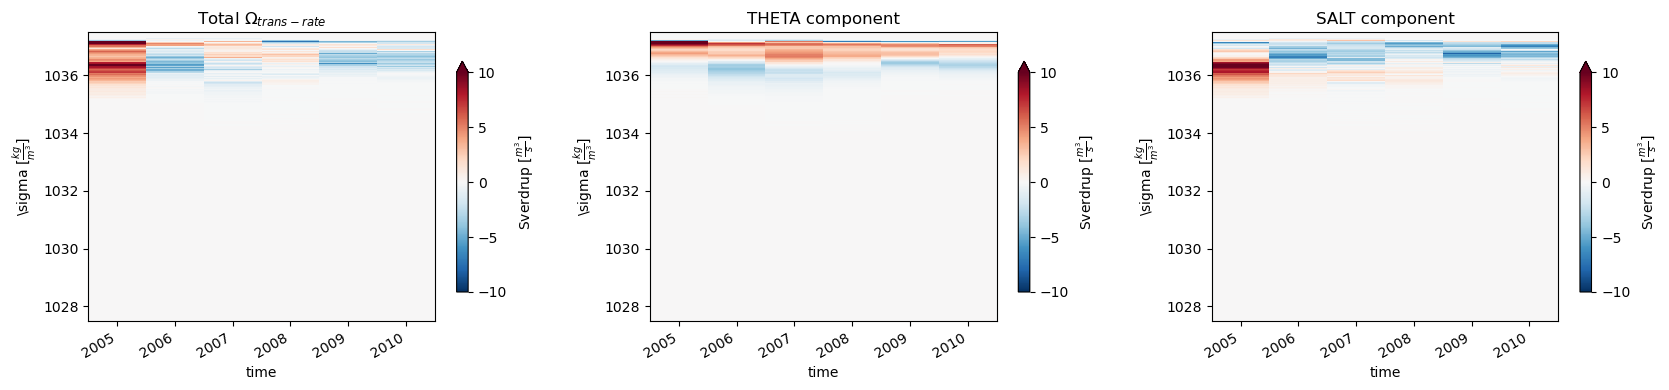

In [178]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(17,4))

(omega_trans_rate.resample(time='AS').mean()/1e6).plot(x='time', ax=ax0, vmax=10,
                                                       cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
#ax0.set_ylim(1037.3, 1035.5)
ax0.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax0.set_title(r'Total $\Omega_{trans-rate}$')

(omega_trans_rate_th.resample(time='AS').mean()/1e6).plot(x='time', ax=ax1, vmax=10,
                                                          cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
#ax1.set_ylim(1037.3, 1035.5)
ax1.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax1.set_title('THETA component')

(omega_trans_rate_slt.resample(time='AS').mean()/1e6).plot(x='time', ax=ax2, vmax=10,
                                                           cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
#ax2.set_ylim(1037.3, 1035.5)
ax2.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax2.set_title('SALT component')

plt.tight_layout();

## <font color='Green'> \begin{equation*} \Psi_{adv} = \Psi_{vel} + R2 \end{equation*} (Numerical Mixing) </font>

## $\Psi_{adv}$

In [179]:
client.restart()

<Client: 'tls://10.2.30.2:8786' processes=2 threads=4, memory=60.00 GiB>

In [180]:
psi_adv_th = (all_dsets_th.OMEGA_conv_horiz_adv_flux_TH + all_dsets_th.OMEGA_conv_vert_adv_flux_TH)
psi_adv_th.load()

<xarray.DataArray (time: 438, sigma2_bin: 999)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time        (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

In [181]:
psi_adv_slt = (all_dsets_slt.OMEGA_conv_horiz_adv_flux_SLT + all_dsets_slt.OMEGA_conv_vert_adv_flux_SLT)
psi_adv_slt.load()

<xarray.DataArray (time: 438, sigma2_bin: 999)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time        (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

In [182]:
psi_adv = psi_adv_th + psi_adv_slt
psi_adv.load()

<xarray.DataArray (time: 438, sigma2_bin: 999)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time        (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

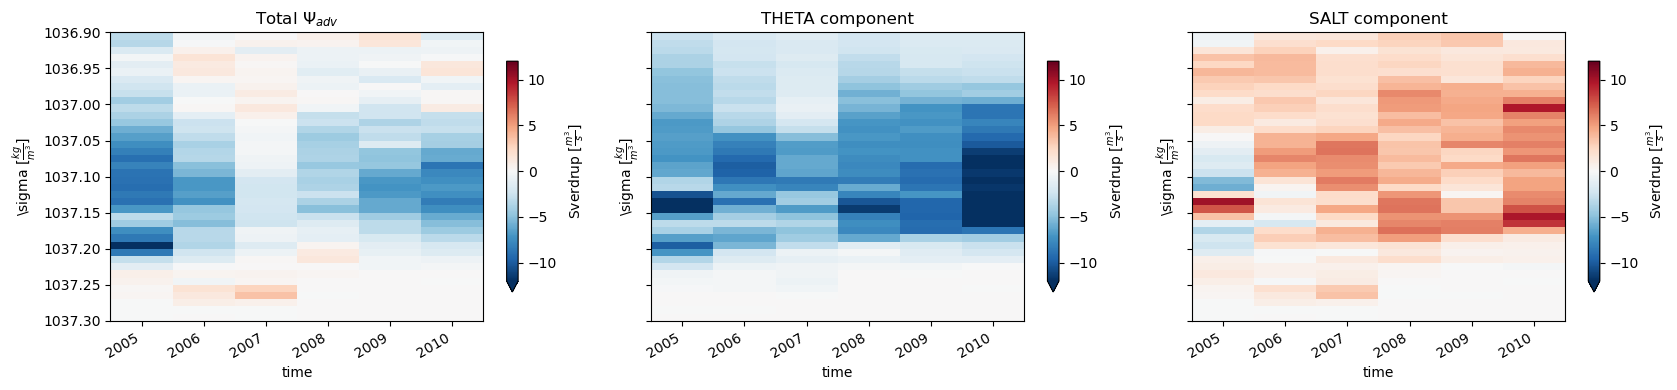

In [185]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, sharey=True, figsize=(17,4))

(psi_adv.resample(time='AS').mean()/1e6).plot(x='time', ax=ax0, vmax=12, yincrease=False,
                                                       cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax0.set_ylim(1037.3, 1036.9)
ax0.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax0.set_title(r'Total $\Psi_{adv}$')

(psi_adv_th.resample(time='AS').mean()/1e6).plot(x='time', ax=ax1, vmax=12, yincrease=False,
                                                          cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax1.set_ylim(1037.3, 1036.9)
ax1.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax1.set_title('THETA component')

(psi_adv_slt.resample(time='AS').mean()/1e6).plot(x='time', ax=ax2, vmax=12, yincrease=False,
                                                           cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax2.set_ylim(1037.3, 1036.9)
ax2.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax2.set_title('SALT component')

plt.tight_layout();

## $\Psi_{vel}$

In [195]:
#testing imported bb module

#area-weighting velocities
UVEL = ds.UVEL * coords.dyG * coords.drF * coords.hFacW
VVEL = ds.VVEL * coords.dxG * coords.drF * coords.hFacS

#testing generalized function for transport

box1_vel = bb.box_budget(UVEL, VVEL, 57, 570, 88, 125)
box2_vel = bb.box_budget(UVEL, VVEL, 36, 570, 77, 88)
box3_vel = bb.box_budget(UVEL, VVEL, 5, 570, 73, 77)
box4_vel = bb.box_budget(UVEL, VVEL, 0, 570, 0, 73)

residual_vel = box1_vel + box2_vel + box3_vel + box4_vel
(residual_vel.mean('time')/1e6).values

array(-0.04375143, dtype=float32)

In [200]:
#right
box1_r_transport = bb.box_budget(UVEL, VVEL, 57, 570, 88, 125, bs='right').load()
box2_r_transport = bb.box_budget(UVEL, VVEL, 36, 570, 77, 88, bs='right').load()
box3_r_transport = bb.box_budget(UVEL, VVEL, 5, 570, 73, 77, bs='right').load()
box4_r_transport = bb.box_budget(UVEL, VVEL, 0, 570, 0, 73, bs='right').load()

u_transport_right = (box1_r_transport.sum(('YC', 'Z')) + box2_r_transport.sum(('YC', 'Z')) + 
                     box3_r_transport.sum(('YC', 'Z')) + box4_r_transport.sum(('YC', 'Z')))

#left
box1_l_transport = bb.box_budget(UVEL, VVEL, 57, 570, 88, 125, bs='left').load()
box2_l_transport = bb.box_budget(UVEL, VVEL, 36, 570, 77, 88, bs='left').load()
box3_l_transport = bb.box_budget(UVEL, VVEL, 5, 570, 73, 77, bs='left').load()
box4_l_transport = bb.box_budget(UVEL, VVEL, 0, 570, 0, 73, bs='left').load()

u_transport_left = (box1_l_transport.sum(('YC', 'Z')) + box2_l_transport.sum(('YC', 'Z')) + 
                    box3_l_transport.sum(('YC', 'Z')) + box4_l_transport.sum(('YC', 'Z')))

#upper
box1_u_transport = bb.box_budget(UVEL, VVEL, 57, 570, 88, 125, bs='upper').load()
box2_u_transport = bb.box_budget(UVEL, VVEL, 36, 570, 77, 88, bs='upper').load()
box3_u_transport = bb.box_budget(UVEL, VVEL, 5, 570, 73, 77, bs='upper').load()
box4_u_transport = bb.box_budget(UVEL, VVEL, 0, 570, 0, 73, bs='upper').load()

v_transport_upper = (box1_u_transport.sum(('XC', 'Z')) + box2_u_transport.sum(('XC', 'Z')) + 
                     box3_u_transport.sum(('XC', 'Z')) + box4_u_transport.sum(('XC', 'Z')))

#lower
box1_lo_transport = bb.box_budget(UVEL, VVEL, 57, 570, 88, 125, bs='lower').load()
box2_lo_transport = bb.box_budget(UVEL, VVEL, 36, 570, 77, 88, bs='lower').load()
box3_lo_transport = bb.box_budget(UVEL, VVEL, 5, 570, 73, 77, bs='lower').load()
box4_lo_transport = bb.box_budget(UVEL, VVEL, 0, 570, 0, 73, bs='lower').load()

v_transport_lower = (box1_lo_transport.sum(('XC', 'Z')) + box2_lo_transport.sum(('XC', 'Z')) + 
                     box3_lo_transport.sum(('XC', 'Z')) + box4_lo_transport.sum(('XC', 'Z')))

In [207]:
#same as residual_vel above
#can switch signs of right/left/upper/lower
residual_vel2 = (-u_transport_right + u_transport_left - v_transport_upper + v_transport_lower)
(residual_vel2.mean('time')/1e6).values

array(-0.04375128)

In [239]:
#right
box1_rhist = histogram(box1_sigma2.isel(XC=-1).rename('sigma2'), bins=[sigma_bins],
                           weights=box1_r_transport, dim=['Z','YC'])
box2_rhist = histogram(box2_sigma2.isel(XC=-1).rename('sigma2'), bins=[sigma_bins],
                           weights=box2_r_transport, dim=['Z','YC'])
box3_rhist = histogram(box3_sigma2.isel(XC=-1).rename('sigma2'), bins=[sigma_bins],
                           weights=box3_r_transport, dim=['Z','YC'])
box4_rhist = histogram(box4_sigma2.isel(XC=-1).rename('sigma2'), bins=[sigma_bins],
                           weights=box4_r_transport, dim=['Z','YC'])

#left
box1_lhist = histogram(box1_sigma2.isel(XC=0).rename('sigma2'), bins=[sigma_bins],
                           weights=box1_l_transport, dim=['Z','YC'])#.load()
box2_lhist = histogram(box2_sigma2.isel(XC=0).rename('sigma2'), bins=[sigma_bins],
                           weights=box2_l_transport, dim=['Z','YC'])#.load()
box3_lhist = histogram(box3_sigma2.isel(XC=0).rename('sigma2'), bins=[sigma_bins],
                           weights=box3_l_transport, dim=['Z','YC'])#.load()
box4_lhist = histogram(box4_sigma2.isel(XC=0).rename('sigma2'), bins=[sigma_bins],
                           weights=box4_l_transport, dim=['Z','YC'])#.load()

#upper
box1_uhist = histogram(box1_sigma2.isel(YC=-1).rename('sigma2'), bins=[sigma_bins],
                           weights=box1_u_transport, dim=['Z','XC'])#.load()
box2_uhist = histogram(box2_sigma2.isel(YC=-1).rename('sigma2'), bins=[sigma_bins],
                           weights=box2_u_transport, dim=['Z','XC'])#.load()
box3_uhist = histogram(box3_sigma2.isel(YC=-1).rename('sigma2'), bins=[sigma_bins],
                           weights=box3_u_transport, dim=['Z','XC'])#.load()
box4_uhist = histogram(box4_sigma2.isel(YC=-1).rename('sigma2'), bins=[sigma_bins],
                           weights=box4_u_transport, dim=['Z','XC'])#.load()

#lower
box1_lohist = histogram(box1_sigma2.isel(YC=0).rename('sigma2'), bins=[sigma_bins],
                           weights=box1_lo_transport, dim=['Z','XC'])#.load()
box2_lohist = histogram(box2_sigma2.isel(YC=0).rename('sigma2'), bins=[sigma_bins],
                           weights=box2_lo_transport, dim=['Z','XC'])#.load()
box3_lohist = histogram(box3_sigma2.isel(YC=0).rename('sigma2'), bins=[sigma_bins],
                           weights=box3_lo_transport, dim=['Z','XC'])#.load()
box4_lohist = histogram(box4_sigma2.isel(YC=0).rename('sigma2'), bins=[sigma_bins],
                           weights=box4_lo_transport, dim=['Z','XC'])#.load()

In [245]:
u_binned_right = (box1_rhist + box2_rhist + box3_rhist + box4_rhist).load()
u_binned_left = (box1_lhist + box2_lhist + box3_lhist + box4_lhist).load()
v_binned_upper = (box1_uhist + box2_uhist + box3_uhist + box4_uhist).load()
v_binned_lower = (box1_lohist + box2_lohist + box3_lohist + box4_lohist).load()

Task exception was never retrieved
future: <Task finished name='Task-27524' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/client.py:2054> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/client.py", line 2063, in wait
    raise AllExit()
distributed.client.AllExit


# Potential Bug: two u_binned, putting into one big computation - dask getting confused as to which u was which.

In [256]:
#`isel` is letting cumsum act in reverse order (from densenst to lightest)
psi_vel = (- u_binned_right + u_binned_left - v_binned_upper
           + v_binned_lower).isel(sigma2_bin=slice(None, None, -1)).cumsum(dim='sigma2_bin')
psi_vel.load()

<xarray.DataArray 'histogram_sigma2' (time: 438, sigma2_bin: 999)>
array([[        0.  ,         0.  ,         0.  , ..., -20609180.  ,
        -20609180.  , -20609180.  ],
       [        0.  ,         0.  ,         0.  , ...,   1502381.5 ,
          1502381.5 ,   1502381.5 ],
       [        0.  ,         0.  ,         0.  , ...,   1240096.1 ,
          1240096.1 ,   1240096.1 ],
       ...,
       [        0.  ,         0.  ,         0.  , ...,  -1412701.4 ,
         -1412701.4 ,  -1412701.4 ],
       [        0.  ,         0.  ,         0.  , ...,   -847199.94,
          -847199.94,   -847199.94],
       [        0.  ,         0.  ,         0.  , ...,    510620.53,
           510620.53,    510620.53]], dtype=float32)
Coordinates:
  * time        (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.028e+03 1.028e+03

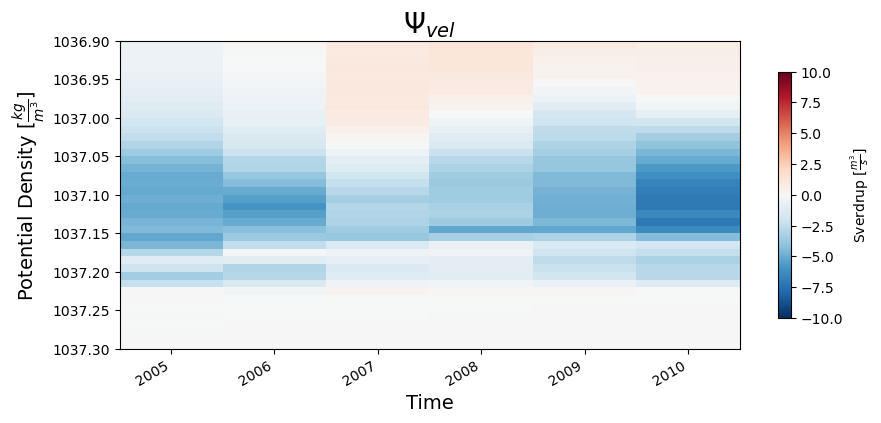

In [257]:
(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', figsize=(10,4), vmax=10, yincrease=False,
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
plt.ylabel(r'Potential Density $[\frac{kg}{m^3}]$', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('$\Psi_{vel}$', fontsize=20)
plt.ylim(1037.3, 1036.9);

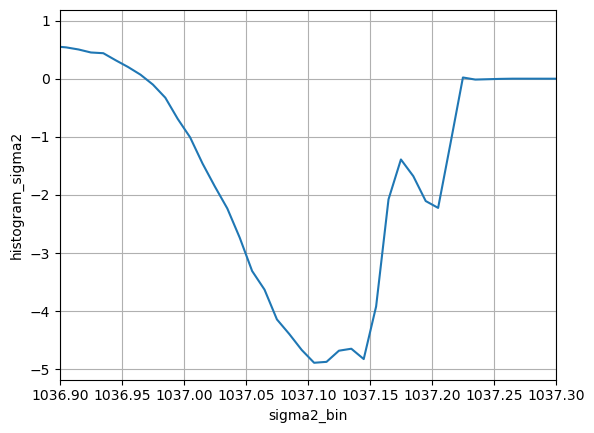

In [268]:
(psi_vel/1e6).mean(dim='time').plot()
plt.xlim(1036.9, 1037.3)
plt.grid();

In [266]:
psi_vel.mean('time').min() /1e6

<xarray.DataArray 'histogram_sigma2' ()>
array(-4.8895785)

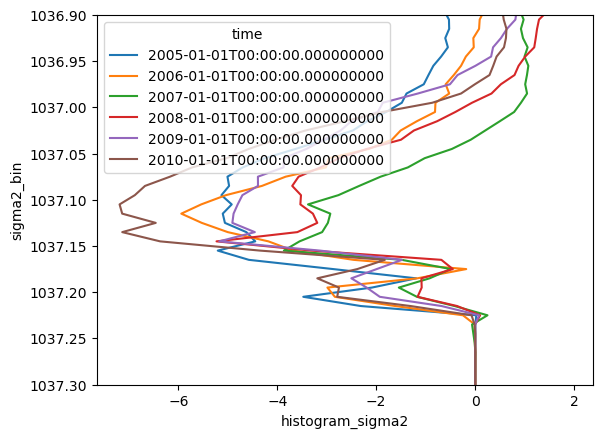

In [267]:
(psi_vel/1e6).resample(time='AS').mean(dim='time').plot.line(y='sigma2_bin', add_legend=True, yincrease=False)
plt.ylim(1037.3, 1036.9);

## R2 = $\Psi_{adv} - \Psi_{vel}$ (Numerical Mixing)

In [269]:
R2 = (psi_adv - psi_vel).load()
R2_th = (psi_adv_th - psi_vel).load()
R2_slt = (psi_adv_slt - psi_vel).load()

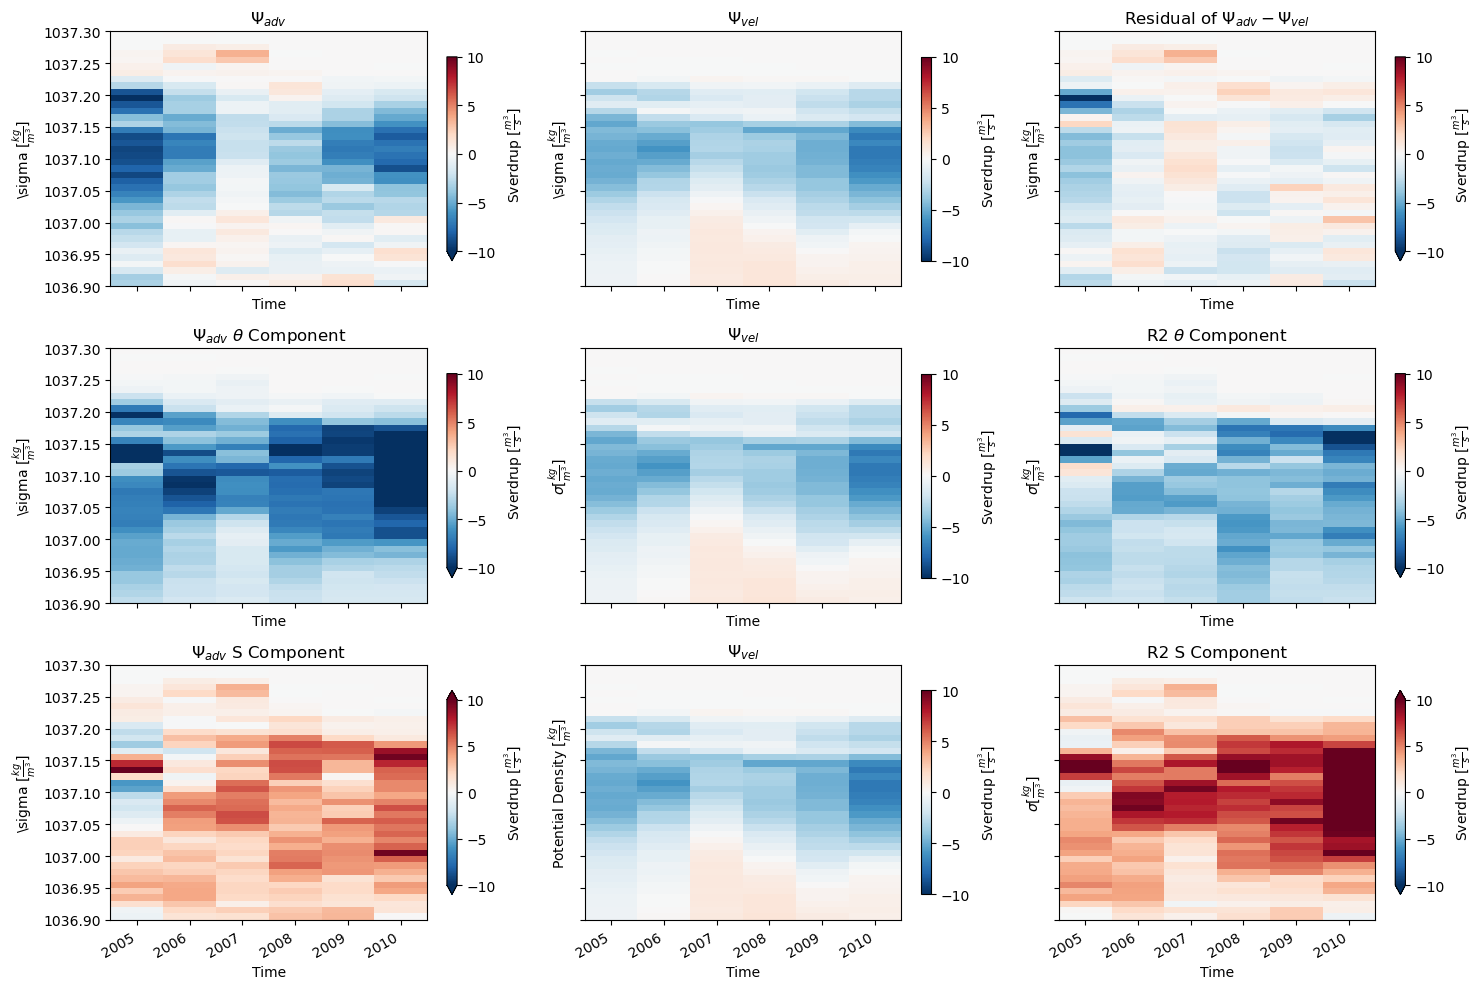

In [273]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharey=True, sharex=True)

(psi_adv/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[0,0], vmax=10,
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[0,0].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[0,0].set_xlabel('Time')
axes[0,0].set_title(r'$\Psi_{adv}$')
axes[0,0].set_ylim(1036.9, 1037.3)

(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[0,1], vmax=10, 
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[0,1].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[0,1].set_xlabel('Time')
axes[0,1].set_title('$\Psi_{vel}$')
#axes[0,1].set_ylim(1037.3, 1035.5)

(R2/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[0,2], vmax=10, 
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[0,2].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[0,2].set_xlabel('Time')
axes[0,2].set_title(r'Residual of $\Psi_{adv} - \Psi_{vel}$')
#axes[0,2].set_ylim(1037.3, 1035.5)

(psi_adv_th/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[1,0], vmax=10,
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[1,0].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[1,0].set_xlabel('Time')
axes[1,0].set_title(r'$\Psi_{adv}$ $\theta$ Component')
#axes[1,0].set_ylim(1037.3, 1035.5)

(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[1,1], vmax=10, 
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[1,1].set_xlabel('Time')
axes[1,1].set_title('$\Psi_{vel}$')
#axes[1,1].set_ylim(1037.3, 1035.5)

(R2_th/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[1,2], vmax=10, 
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[1,2].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[1,2].set_xlabel('Time')
axes[1,2].set_title(r'R2 $\theta$ Component')
#axes[1,2].set_ylim(1037.3, 1035.5)

(psi_adv_slt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[2,0], vmax=10,
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[2,0].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[2,0].set_xlabel('Time')
axes[2,0].set_title(r'$\Psi_{adv}$ S Component')
#axes[2,0].set_ylim(1037.3, 1035.5)

(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[2,1], vmax=10, 
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[2,1].set_ylabel(r'Potential Density $[\frac{kg}{m^3}]$')
axes[2,1].set_xlabel('Time')
axes[2,1].set_title('$\Psi_{vel}$')
#axes[2,1].set_ylim(1037.3, 1035.5)

(R2_slt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[2,2], vmax=10, 
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[2,2].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[2,2].set_xlabel('Time')
axes[2,2].set_title(r'R2 S Component')
axes[2,2].set_ylim(1036.9, 1037.3)

plt.tight_layout();

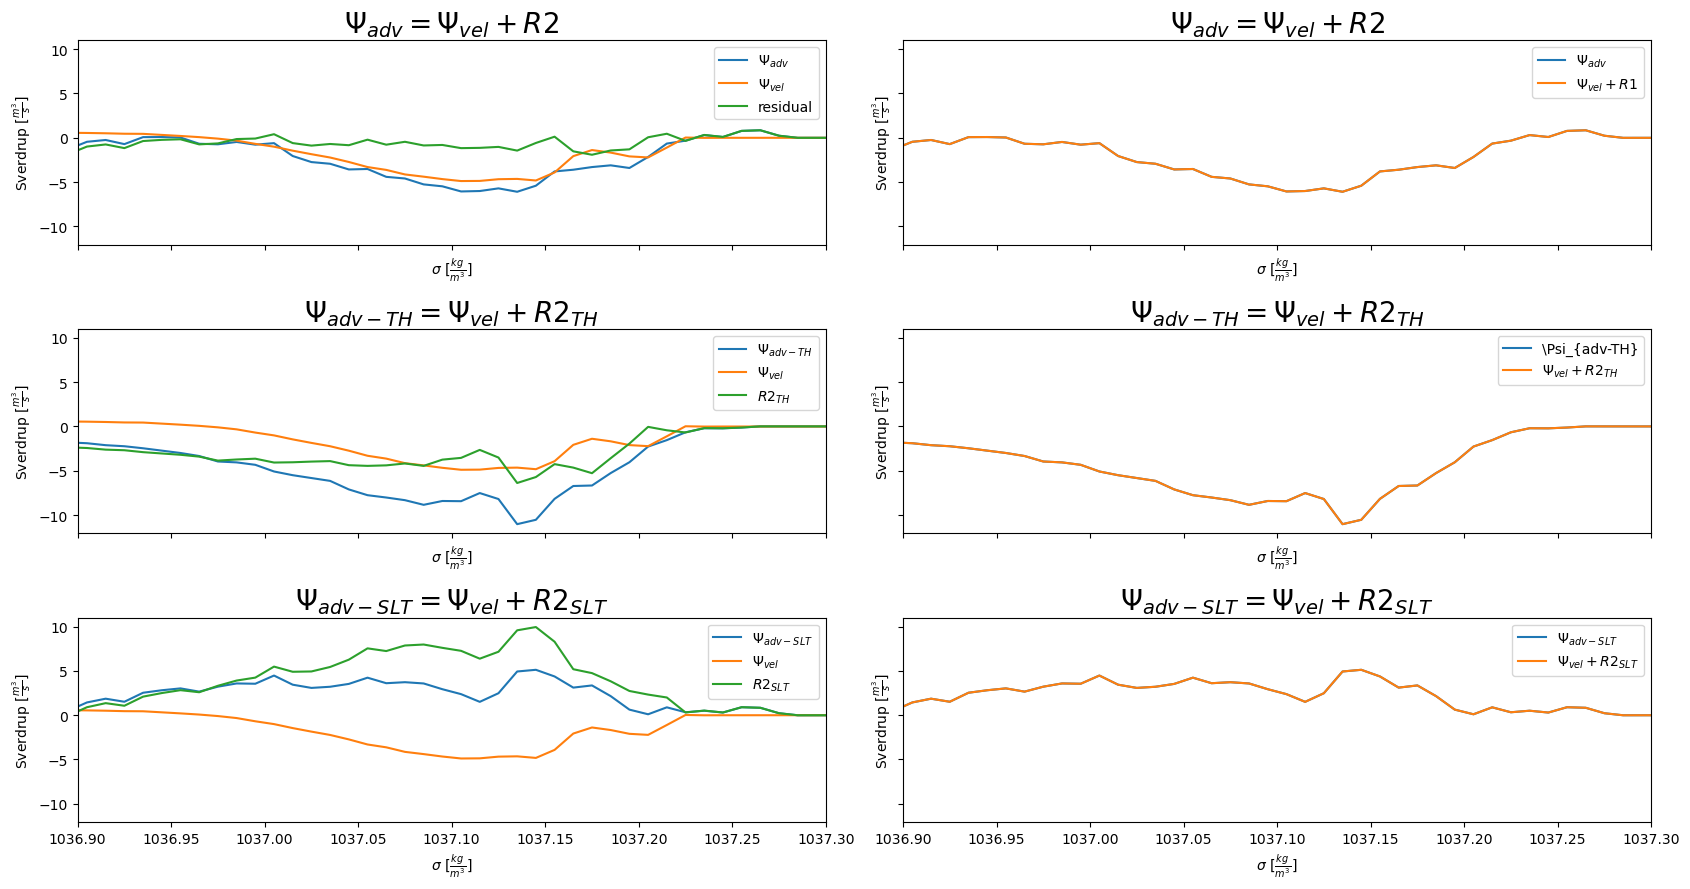

In [274]:
fig, axes = plt.subplots(3, 2, figsize=(17, 9), sharey=True, sharex=True)

(psi_adv/1e6).mean(dim='time').plot(label=r'$\Psi_{adv}$', ax=axes[0,0])
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi_{vel}$', ax=axes[0,0])
(R2/1e6).mean(dim='time').plot(label='residual', ax=axes[0,0])
axes[0,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[0,0].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[0,0].legend()
axes[0,0].set_title(r'$\Psi_{adv} = \Psi_{vel} + R2$', fontsize=20)
#axes[0,0].set_xlim(1037.3, 1035.5)

(psi_adv/1e6).mean(dim='time').plot(label=r'$\Psi_{adv}$', ax=axes[0,1])
((psi_vel + R2)/1e6).mean(dim='time').plot(label=r'$\Psi_{vel} + R1$', ax=axes[0,1])
axes[0,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[0,1].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[0,1].legend()
axes[0,1].set_title(r'$\Psi_{adv} = \Psi_{vel} + R2$', fontsize=20)
#axes[0,1].set_xlim(1037.3, 1035.5)

(psi_adv_th/1e6).mean(dim='time').plot(label=r'$\Psi_{adv-TH}$', ax=axes[1,0])
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi_{vel}$', ax=axes[1,0])
(R2_th/1e6).mean(dim='time').plot(label=r'$R2_{TH}$', ax=axes[1,0])
axes[1,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[1,0].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[1,0].legend()
axes[1,0].set_title(r'$\Psi_{adv-TH} = \Psi_{vel} + R2_{TH}$ ', fontsize=20)
#axes[1,0].set_xlim(1037.3, 1035.5)

(psi_adv_th/1e6).mean(dim='time').plot(label='\Psi_{adv-TH}', ax=axes[1,1])
((psi_vel + R2_th)/1e6).mean(dim='time').plot(label=r'$\Psi_{vel} + R2_{TH}$', ax=axes[1,1])
axes[1,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[1,1].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[1,1].legend()
axes[1,1].set_title(r'$\Psi_{adv-TH} = \Psi_{vel} + R2_{TH}$', fontsize=20)
#axes[1,1].set_xlim(1037.3, 1035.5)

(psi_adv_slt/1e6).mean(dim='time').plot(label=r'$\Psi_{adv-SLT}$', ax=axes[2,0])
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi_{vel}$', ax=axes[2,0])
(R2_slt/1e6).mean(dim='time').plot(label=r'$R2_{SLT}$', ax=axes[2,0])
axes[2,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[2,0].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[2,0].legend()
axes[2,0].set_title(r'$\Psi_{adv-SLT} = \Psi_{vel} + R2_{SLT}$', fontsize=20)
#axes[2,0].set_xlim(1037.3, 1035.5)

(psi_adv_slt/1e6).mean(dim='time').plot(label=r'$\Psi_{adv-SLT}$', ax=axes[2,1])
((psi_vel + R2_slt)/1e6).mean(dim='time').plot(label=r'$\Psi_{vel} + R2_{SLT}$', ax=axes[2,1])
axes[2,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[2,1].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[2,1].legend()
axes[2,1].set_title(r'$\Psi_{adv-SLT} = \Psi_{vel} + R2_{SLT}$', fontsize=20)
axes[2,1].set_xlim(1036.9, 1037.3)

plt.tight_layout();

# <font color='Green'>\begin{equation*} \Omega_{tottend-truth} = \Psi_{adv} + \Omega_{trans-rate} + R3 \end{equation*} </font>

In [275]:
R3_th = omega_total_th - (psi_adv_th + omega_trans_rate_th)
R3_th.load()
R3_slt = omega_total_slt - (psi_adv_slt + omega_trans_rate_slt)
R3_slt.load()
R3 = omega_total - (psi_adv + omega_trans_rate)
R3.load()

<xarray.DataArray (time: 438, sigma2_bin: 999)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time        (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

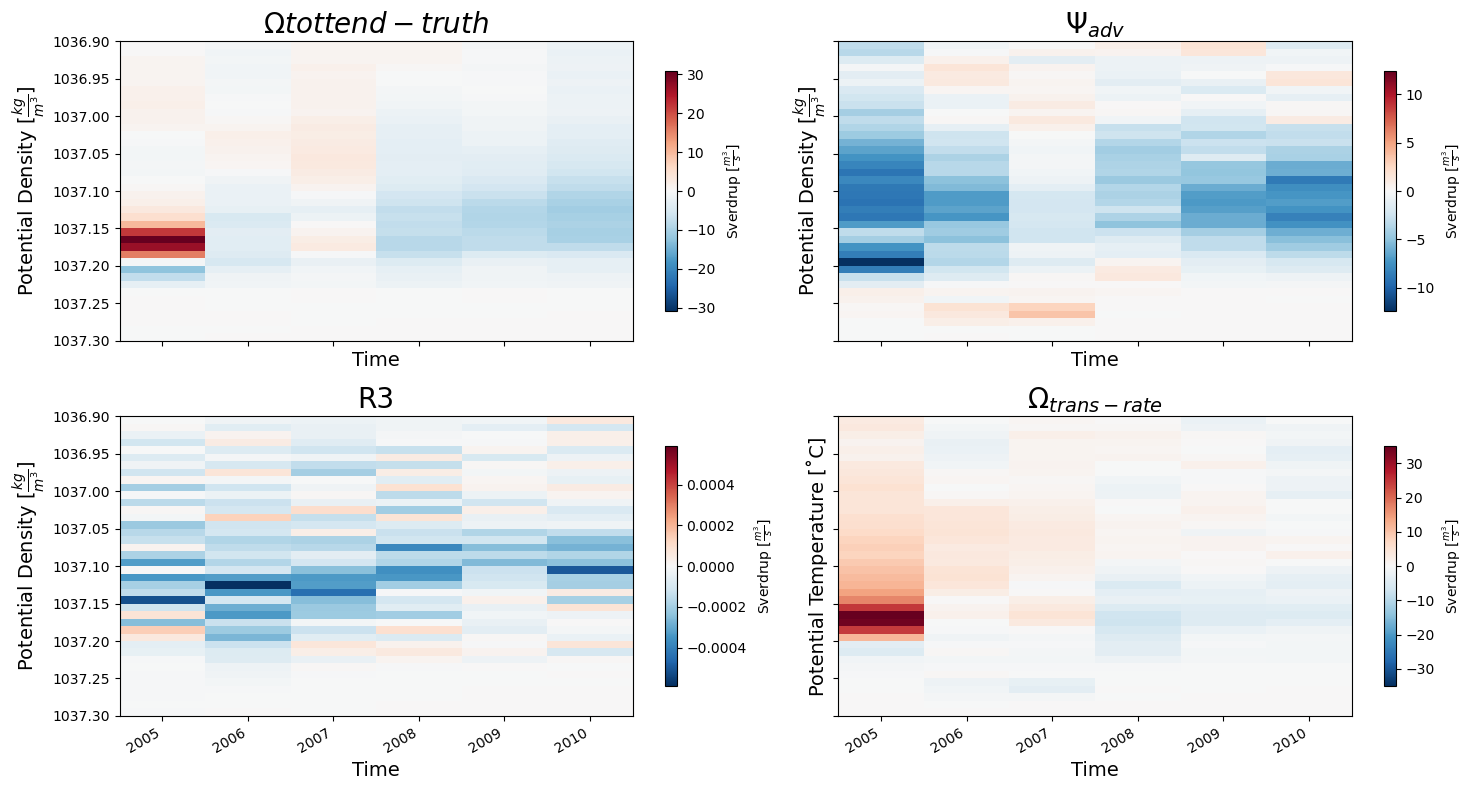

In [277]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8), sharey=True, sharex=True)

(omega_total/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax[0,0],
                                                     cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax[0,0].set_ylabel(r'Potential Density $[\frac{kg}{m^3}]$', fontsize=14)
ax[0,0].set_xlabel('Time', fontsize=14)
ax[0,0].set_title(r'$\Omega{tottend-truth}$', fontsize=20)
#ax[0,0].set_ylim(1036.4, 1037.3)

(psi_adv/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax[0,1], 
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax[0,1].set_ylabel(r'Potential Density $[\frac{kg}{m^3}]$', fontsize=14)
ax[0,1].set_xlabel('Time', fontsize=14)
ax[0,1].set_title('$\Psi_{adv}$', fontsize=20)
#ax[0,1].set_ylim(1036.4, 1037.3)

(R3/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax[1,0], 
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax[1,0].set_ylabel(r'Potential Density $[\frac{kg}{m^3}]$', fontsize=14)
ax[1,0].set_xlabel('Time', fontsize=14)
ax[1,0].set_title(r'R3', fontsize=20)
#ax[1,0].set_ylim(1036.4, 1037.3)

(omega_trans_rate/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax[1,1], 
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax[1,1].set_ylabel('Potential Temperature [˚C]', fontsize=14)
ax[1,1].set_xlabel('Time', fontsize=14)
ax[1,1].set_title('$\Omega_{trans-rate}$', fontsize=20)
ax[1,1].set_ylim(1037.3, 1036.9)

plt.tight_layout();

(1036.9, 1037.3)

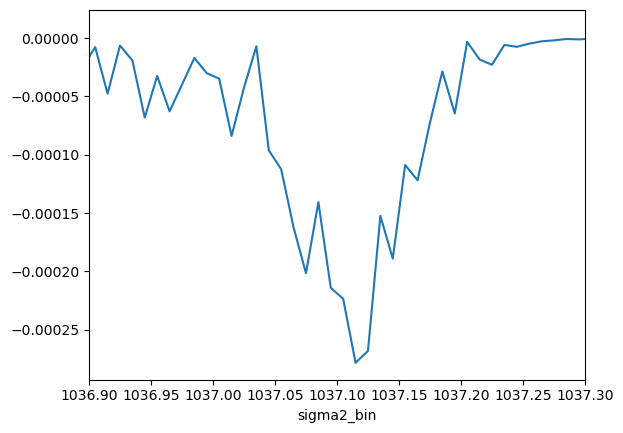

In [278]:
(R3/1e6).mean(dim='time').plot()
plt.xlim(1036.9, 1037.3)

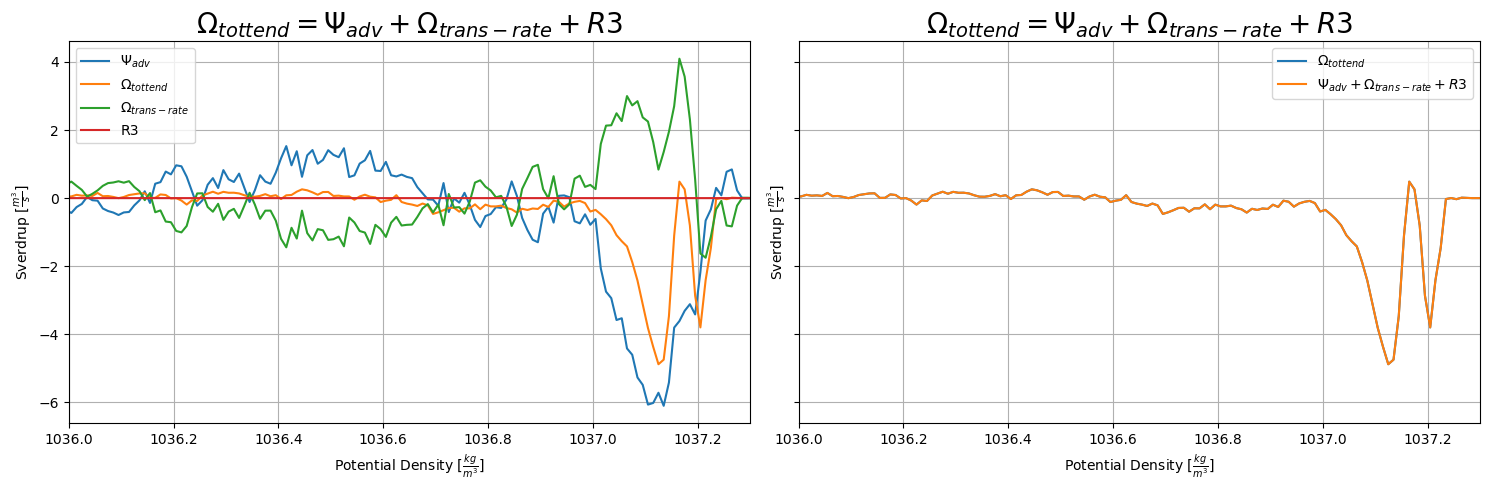

In [281]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 5), sharey=True, sharex=True)

(psi_adv/1e6).mean(dim='time').plot(label=r'$\Psi_{adv}$', ax=ax0)
(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=ax0)
(omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega_{trans-rate}$', ax=ax0)
(R3/1e6).mean(dim='time').plot(label='R3', ax=ax0)
ax0.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax0.set_xlabel(r'Potential Density $[\frac{kg}{m^3}]$')
ax0.legend()
ax0.grid()
ax0.set_title(r'$\Omega_{tottend} = \Psi_{adv} + \Omega_{trans-rate} + R3$', fontsize=20)
#ax0.set_xlim(1036.4, 1037.3)

(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=ax1)
((psi_adv + omega_trans_rate + R3)/1e6).mean(dim='time').plot(label=r'$\Psi_{adv}+\Omega_{trans-rate}+R3$', ax=ax1)
ax1.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax1.set_xlabel(r'Potential Density $[\frac{kg}{m^3}]$')
ax1.legend()
ax1.grid()
ax1.set_title(r'$\Omega_{tottend} = \Psi_{adv} + \Omega_{trans-rate} + R3$', fontsize=20)
ax1.set_xlim(1036, 1037.3)

plt.tight_layout();

(1036.0, 1037.5)

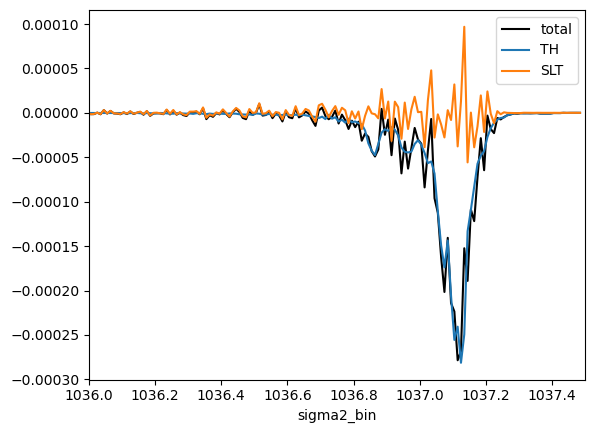

In [284]:
(R3/1e6).mean(dim='time').plot(color='k', label='total')
(R3_th/1e6).mean(dim='time').plot(label='TH')
(R3_slt/1e6).mean(dim='time').plot(label='SLT')
plt.legend()
plt.xlim(1036, 1037.5)

(1036.0, 1037.5)

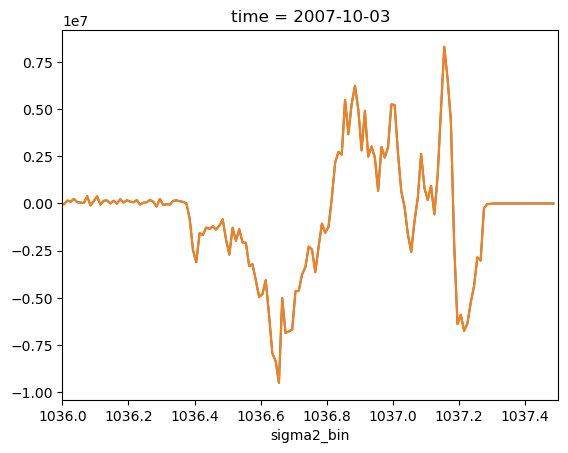

In [286]:
n = 200
omega_total.isel(time=n).plot()
(omega_trans_rate + psi_adv).isel(time=n).plot()
plt.xlim(1036, 1037.5)

# <font color='Green'>\begin{equation*} \frac{\partial V}{\partial t} = \Psi_{vel} + R2 + \Omega_{trans-rate} + R3 + R1 \end{equation*} </font>

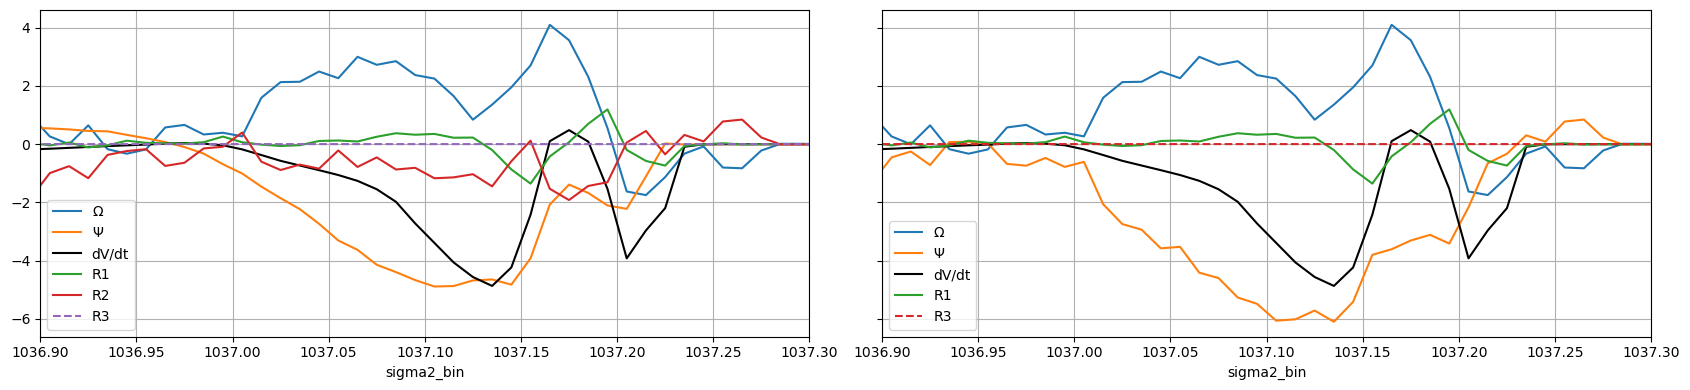

In [289]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(17, 4), sharey=True, sharex=True)

(omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega$', ax=ax0)
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$', ax=ax0)
(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', ax=ax0)
(R1/1e6).mean(dim='time').plot(label='R1', ax=ax0)
(R2/1e6).mean(dim='time').plot(label='R2', ax=ax0)
(R3/1e6).mean(dim='time').plot(label='R3', ax=ax0, linestyle='--')
ax0.legend()
ax0.grid()
#ax0.set_xlim(1036.4, 1037.3)

(omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega$', ax=ax1)
(psi_adv/1e6).mean(dim='time').plot(label=r'$\Psi$', ax=ax1)
(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', ax=ax1)
(R1/1e6).mean(dim='time').plot(label='R1', ax=ax1)
(R3/1e6).mean(dim='time').plot(label='R3', ax=ax1, linestyle='--')
ax1.legend()
ax1.grid()
ax1.set_xlim(1036.9, 1037.3)
plt.tight_layout();

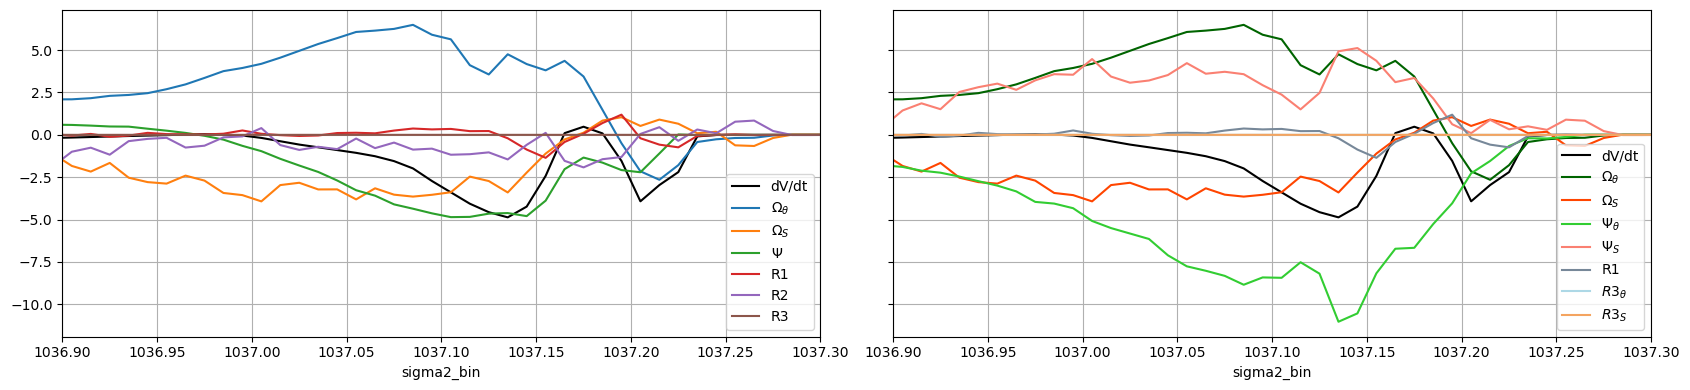

In [291]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(17, 4), sharey=True, sharex=True)

(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', ax=ax0)
(omega_trans_rate_th/1e6).mean(dim='time').plot(label=r'$\Omega_{\theta}$', ax=ax0)
(omega_trans_rate_slt/1e6).mean(dim='time').plot(label=r'$\Omega_S$', ax=ax0)
(psi_vel[1:-1]/1e6).mean(dim='time').plot(label=r'$\Psi$', ax=ax0)

(R1/1e6).mean(dim='time').plot(label='R1', ax=ax0)
(R2/1e6).mean(dim='time').plot(label='R2', ax=ax0)
(R3/1e6).mean(dim='time').plot(label='R3', ax=ax0)
ax0.legend()
ax0.grid()
#ax0.set_xlim(1036.4, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', ax=ax1)
(omega_trans_rate_th/1e6).mean(dim='time').plot(label=r'$\Omega_{\theta}$', ax=ax1, color='darkgreen')
(omega_trans_rate_slt/1e6).mean(dim='time').plot(label=r'$\Omega_S$', ax=ax1, color='orangered')
(psi_adv_th/1e6).mean(dim='time').plot(label=r'$\Psi_{\theta}$', ax=ax1, color='limegreen')
(psi_adv_slt/1e6).mean(dim='time').plot(label=r'$\Psi_S$', ax=ax1, color='salmon')
(R1/1e6).mean(dim='time').plot(label='R1', ax=ax1, color='lightslategray')
(R3_th/1e6).mean(dim='time').plot(label=r'$R3_{\theta}$', ax=ax1, color='lightblue')
(R3_slt/1e6).mean(dim='time').plot(label=r'$R3_S$', ax=ax1, color='sandybrown')
ax1.legend()
ax1.grid()
ax1.set_xlim(1036.9, 1037.3)
plt.tight_layout();

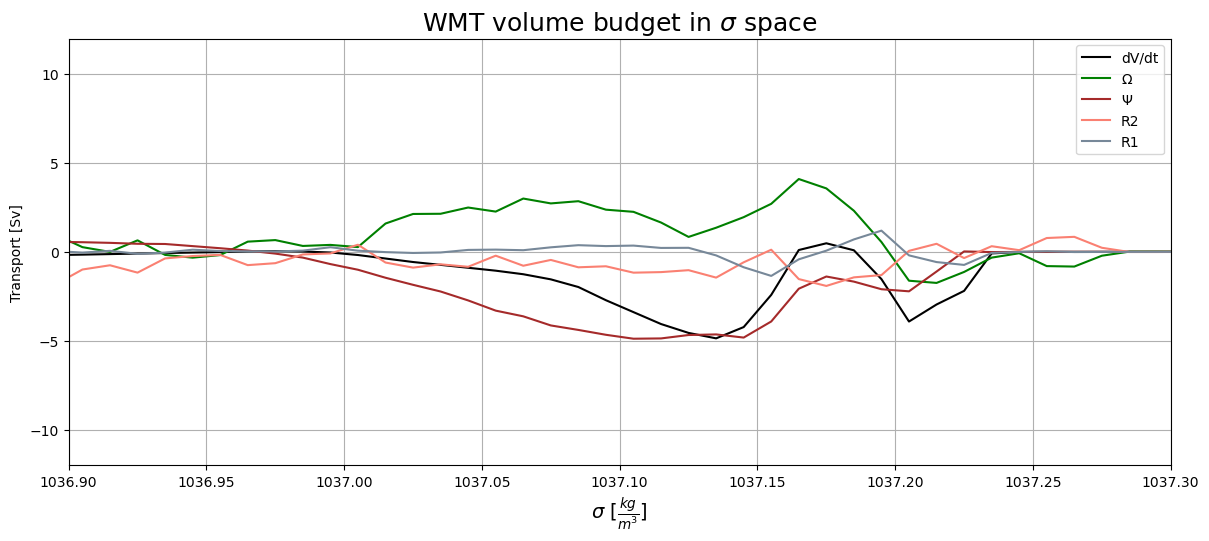

In [293]:
(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', figsize=(12,5))
(omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega$', color='green')
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$', color='brown')
(R2/1e6).mean(dim='time').plot(label='R2', color='salmon')
(R1/1e6).mean(dim='time').plot(label='R1', color='lightslategray')
#(R3[1:-1]/1e6).mean(dim='time').plot(label=r'$R3$', color='mediumspringgreen')
plt.legend()
plt.grid()
plt.xlim(1036.9, 1037.3)
plt.ylim(-12, 12)
plt.tight_layout()
plt.xlabel(r'$\sigma$ $[\frac{kg}{m^3}]$', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.title(r'WMT volume budget in $\sigma$ space', fontsize=18);

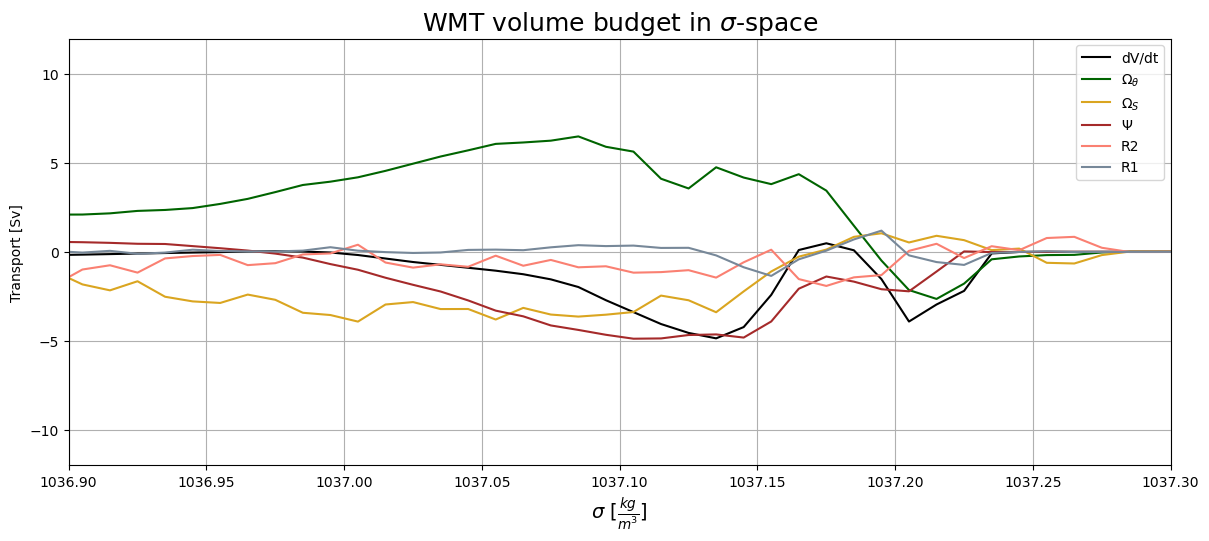

In [294]:
(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', figsize=(12,5))
(omega_trans_rate_th/1e6).mean(dim='time').plot(label=r'$\Omega_{\theta}$', color='darkgreen')
(omega_trans_rate_slt/1e6).mean(dim='time').plot(label=r'$\Omega_S$', color='goldenrod')
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$', color='brown')
(R2/1e6).mean(dim='time').plot(label='R2', color='salmon')
(R1/1e6).mean(dim='time').plot(label='R1', color='lightslategray')
#(R3[1:-1]/1e6).mean(dim='time').plot(label=r'$R3$', color='mediumspringgreen')
plt.legend()
plt.grid()
plt.ylim(-12, 12)
plt.xlim(1036.9, 1037.3)
plt.tight_layout()
plt.xlabel(r'$\sigma$ $[\frac{kg}{m^3}]$', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.title(r'WMT volume budget in $\sigma$-space', fontsize=18);

In [295]:
import pandas as pd

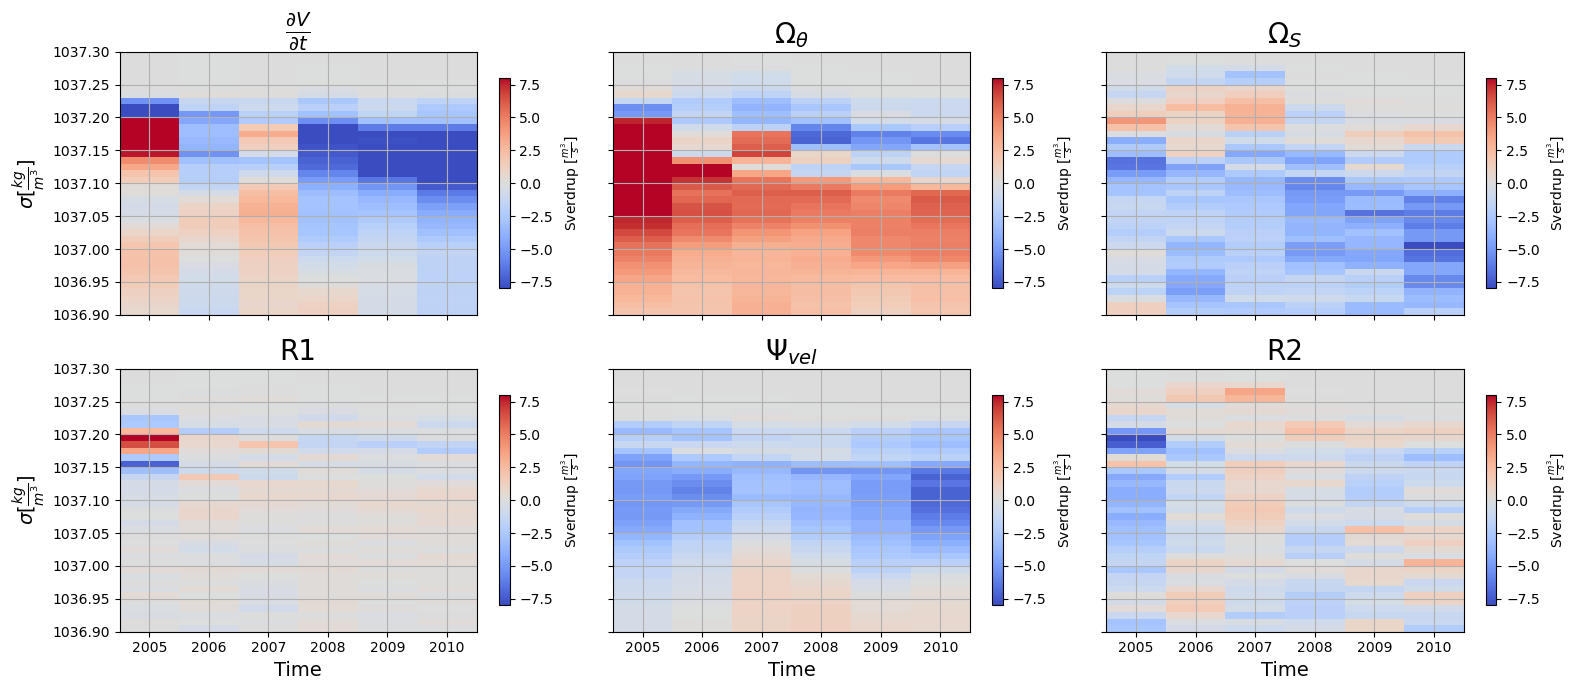

In [298]:
fig, ax = plt.subplots(2, 3, figsize=(16, 7), sharey=True, sharex=True)

dVdt_resampled = dVdt.resample(time='AS').mean(dim='time') / 1e6
c = ax[0,0].pcolormesh(pd.to_datetime(dVdt_resampled.time), 
                   dVdt_resampled.sigma2_bin, 
                   dVdt_resampled.T, vmin=-8, vmax=8, cmap='coolwarm')
plt.colorbar(c, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[0,0])
ax[0,0].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax[0,0].set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20)
#ax[0,0].set_ylim(1037.3, 1036.3)
ax[0,0].grid()

omega_th_resampled = (omega_trans_rate_th/1e6).resample(time='AS').mean(dim='time')
c0 = ax[0,1].pcolormesh(pd.to_datetime(omega_th_resampled.time), omega_th_resampled.sigma2_bin, omega_th_resampled.T,
                        cmap='coolwarm', vmin=-8, vmax=8)
plt.colorbar(c0, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[0,1])
#ax[0,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,1].set_xlabel('Time', fontsize=14)
ax[0,1].set_title(r'$\Omega_{\theta}$', fontsize=20)
#ax[0,1].set_ylim(1037.3, 1036.3)
ax[0,1].grid()

omega_slt_resampled = (omega_trans_rate_slt/1e6).resample(time='AS').mean(dim='time')
c1 = ax[0,2].pcolormesh(pd.to_datetime(omega_slt_resampled.time), omega_slt_resampled.sigma2_bin, omega_slt_resampled.T,
                        cmap='coolwarm', vmin=-8, vmax=8)
plt.colorbar(c1, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[0,2])
#ax[0,2].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,2].set_xlabel('Time', fontsize=14)
ax[0,2].set_title(r'$\Omega_{S}$', fontsize=20)
#ax[0,2].set_ylim(1037.3, 1036.3)
ax[0,2].grid()

R1_resampled = (R1/1e6).resample(time='AS').mean(dim='time')
c2 = ax[1,0].pcolormesh(pd.to_datetime(R1_resampled.time), R1_resampled.sigma2_bin, R1_resampled.T,
                             cmap='coolwarm', vmin=-8, vmax=8)
plt.colorbar(c2, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[1,0])
ax[1,0].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,0].set_xlabel('Time', fontsize=14)
ax[1,0].set_title('R1', fontsize=20)
#ax[1,0].set_ylim(1037.3, 1036.3)
ax[1,0].grid()

psi_vel_resampled = (psi_vel/1e6).resample(time='AS').mean(dim='time')
c3 = ax[1,1].pcolormesh(pd.to_datetime(psi_vel_resampled.time), psi_vel_resampled.sigma2_bin, psi_vel_resampled.T,
                        cmap='coolwarm', vmin=-8, vmax=8)
plt.colorbar(c3, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax[1,1])
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,1].set_xlabel('Time', fontsize=14)
ax[1,1].set_title(r'$\Psi_{vel}$', fontsize=20)
#ax[1,1].set_ylim(1037.3, 1036.3)
ax[1,1].grid()

R2_resampled = (R2/1e6).resample(time='AS').mean(dim='time')
c4 = ax[1,2].pcolormesh(pd.to_datetime(R2_resampled.time), R2_resampled.sigma2_bin, R2_resampled.T,
                             cmap='coolwarm', vmin=-8, vmax=8)
plt.colorbar(c4, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax[1,2])
#ax[1,2].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,2].set_xlabel('Time', fontsize=14)
ax[1,2].set_title('R2', fontsize=20)
ax[1,2].set_ylim(1036.9, 1037.3)
ax[1,2].grid()
plt.tight_layout();

In [299]:
dVdt_resampled = dVdt.resample(time='AS').mean(dim='time') / 1e6

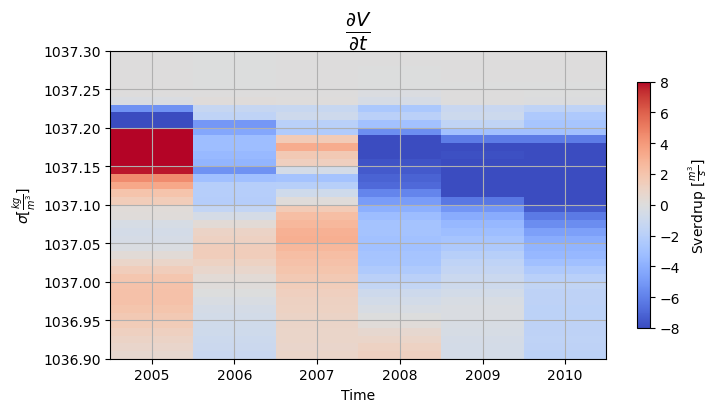

In [303]:
plt.figure(figsize=(8,4))
c = plt.pcolormesh(pd.to_datetime(dVdt_resampled.time), 
                   dVdt_resampled.sigma2_bin, 
                   dVdt_resampled.T, vmin=-8, vmax=8, cmap='coolwarm')
plt.colorbar(c, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$')
plt.grid()
plt.ylabel(r'$\sigma [\frac{kg}{m^3}]$')
plt.xlabel('Time')
plt.title(r'$\frac{\partial V}{\partial t}$', fontsize=20)
plt.ylim(1036.9, 1037.3);

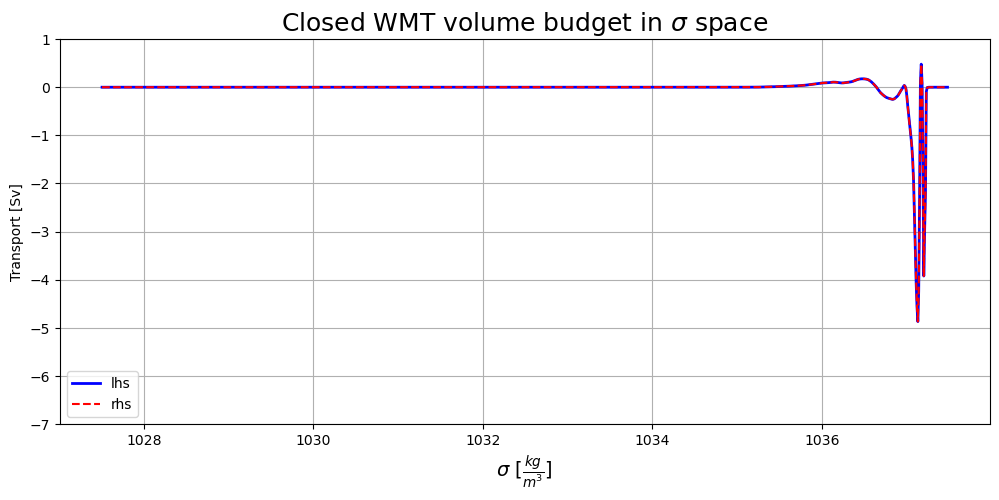

In [300]:
(dVdt/1e6).mean(dim='time').plot(label='lhs', color='blue', linewidth=2, figsize=(12,5)) 
((omega_trans_rate + psi_adv + R1)/1e6).mean(dim='time').plot(color='red', linestyle='dashed', label='rhs')
#plt.title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega + \Psi + R3 + R1$', fontsize=18)
plt.title(r'Closed WMT volume budget in $\sigma$ space', fontsize=18)
plt.legend()
plt.xlabel(r'$\sigma$ $[\frac{kg}{m^3}]$', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.grid()
plt.ylim(-7,1);
#plt.xlim(1035.5, 1037.3);

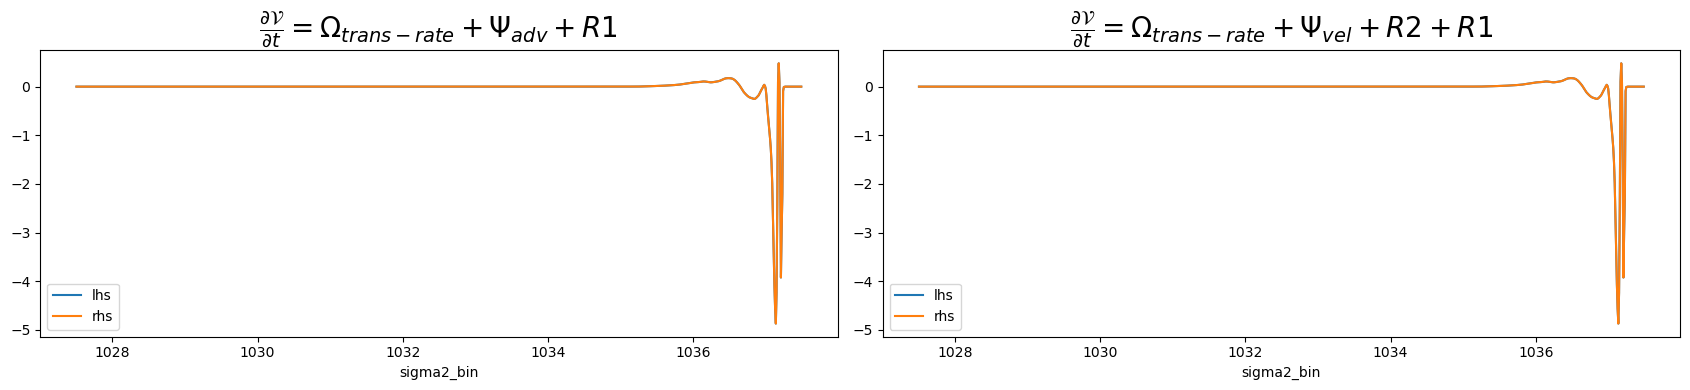

In [301]:
fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(17,4))

(dVdt/1e6).mean(dim='time').plot(label='lhs', ax=ax0) 
((omega_trans_rate + psi_adv + R1)/1e6).mean(dim='time').plot(label='rhs', ax=ax0)
ax0.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{trans-rate} + \Psi_{adv} + R1$', fontsize=20, fontweight='bold')
ax0.legend()
#ax0.set_xlim(1036.5, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='lhs', ax=ax1) 
((omega_trans_rate + R1 + psi_vel + R2)/1e6).mean(dim='time').plot(label='rhs', ax=ax1)
ax1.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{trans-rate} + \Psi_{vel} + R2 + R1$', fontsize=20, fontweight='bold')
ax1.legend()
#ax1.set_xlim(1036.5, 1037.3)

plt.tight_layout();

## Breaking up $\Omega_{trans-rate}$ term

In [311]:
omega_mix_th = (all_dsets_th.OMEGA_conv_horiz_diff_flux_TH + 
                  all_dsets_th.OMEGA_conv_vert_diff_flux_TH).load()
omega_mix_slt = (all_dsets_slt.OMEGA_conv_horiz_diff_flux_SLT + 
                   all_dsets_slt.OMEGA_conv_vert_diff_flux_SLT).load()
omega_surf_th = (all_dsets_th.OMEGA_sw_flux_conv_TH + 
                  all_dsets_th.OMEGA_surface_flux_conv_TH +
                  all_dsets_th.OMEGA_lin_fs_correction_TH).load()
omega_surf_slt = (all_dsets_slt.OMEGA_surface_flux_conv_SLT +
                     all_dsets_slt.OMEGA_lin_fs_correction_SLT).load()

omega_surf = (omega_surf_th + omega_surf_slt).load()
omega_mix = (omega_mix_th + omega_mix_slt).load()

## Saving WMT budget terms to GCS zarr

In [312]:
wmt_budget_terms = xr.merge([dVdt.rename('dVdt'), R1.rename('R1'),
                             R1_th.rename('R1_th'), R1_slt.rename('R1_slt'),
                             omega_total.rename('omega_total'),
                             omega_total_th.rename('omega_total_th'),
                             omega_total_slt.rename('omega_total_slt'),
                             omega_tot_2nd.rename('omega_total_2nd'),
                             psi_adv.rename('psi_adv'),
                             psi_adv_th.rename('psi_adv_th'),
                             psi_adv_slt.rename('psi_adv_slt'),
                             psi_vel.rename('psi_vel'), R2.rename('R2'),
                             R2_th.rename('R2_th'), R2_slt.rename('R2_slt'),
                             omega_trans_rate.rename('omega_trans_rate'),
                             omega_trans_rate_th.rename('omega_trans_rate_th'),
                             omega_trans_rate_slt.rename('omega_trans_rate_slt'),
                             omega_surf.rename('omega_surf'),
                             omega_surf_slt.rename('omega_surf_slt'),
                             omega_surf_th.rename('omega_surf_th'), 
                             omega_mix.rename('omega_mix'), 
                             omega_mix_th.rename('omega_mix_th'),
                             omega_mix_slt.rename('omega_mix_slt'),
                             R3.rename('R3'), R3_th.rename('R3_th'), R3_slt.rename('R3_slt')])

In [313]:
wmt_budget_terms

<xarray.Dataset>
Dimensions:               (time: 438, sigma2_bin: 999)
Coordinates:
  * time                  (time) datetime64[ns] 2005-01-06 ... 2010-12-31
  * sigma2_bin            (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03
Data variables: (12/27)
    dVdt                  (time, sigma2_bin) float64 nan nan nan ... 0.0 0.0 0.0
    R1                    (time, sigma2_bin) float64 nan nan nan ... 0.0 0.0 0.0
    R1_th                 (time, sigma2_bin) float64 nan nan nan ... 0.0 0.0 0.0
    R1_slt                (time, sigma2_bin) float64 nan nan nan ... 0.0 0.0 0.0
    omega_total           (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_total_th        (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...                    ...
    omega_mix             (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_mix_th          (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_mix_slt         (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    R3                    (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    R3_th                 (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    R3_slt                (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [314]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [315]:
# saving wmt budget terms to gcs
gcsmap_wmt_budget_terms = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/models/SOSE/wmt_budget_terms.zarr')
wmt_budget_terms.to_zarr(gcsmap_wmt_budget_terms, mode='w')